In [1]:
print("Hello world!")

Hello world!


In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, recall_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier as RFC
from tabulate import tabulate

In [3]:
X_nt = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_non_test_set.csv", index_col = 0)
X_t = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_test_set.csv", index_col = 0)
X = pd.concat([X_nt, X_t])
y = X.pop("RECURRENCE")
y_nt = X_nt.pop("RECURRENCE")
y_t = X_t.pop("RECURRENCE")

In [4]:
imputer_r = SimpleImputer(strategy = 'constant', fill_value = 0)
scaler_r = StandardScaler()
X_nt_s_i = scaler_r.fit_transform(imputer_r.fit_transform(X_nt))
X_t_s_i = scaler_r.transform(imputer_r.transform(X_t))
majority_X_nt = X_nt_s_i[y_nt == 0]
minority_X_nt = X_nt_s_i[y_nt == 1]
majority_y_nt = y_nt[y_nt == 0]
minority_y_nt = y_nt[y_nt == 1]
oversampled_X_min, oversampled_y_min = resample(minority_X_nt, minority_y_nt, replace = True, n_samples = len(majority_X_nt), random_state = 42)
X_nt_ov = np.concatenate((majority_X_nt, oversampled_X_min))
y_nt_ov = np.concatenate((majority_y_nt, oversampled_y_min))

In [5]:
X_nt_ov.shape, y_nt_ov.shape

((848, 27), (848,))

In [6]:
def grid_searcher(param_grid, estimator, scoring, X_train = X_nt_ov, y_train = y_nt_ov, cv = 10, verbose = 1):
    tic = time.time()
    grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = cv, scoring = scoring, n_jobs = -1, verbose = verbose)
    grid_search.fit(X_train, y_train)
    toc = time.time()
    print(f"Time taken: {toc - tic} seconds")
    best_params = grid_search.best_params_
    print(f"Best Hyperparameters: {best_params}")
    best_model = grid_search.best_estimator_
    # cv_results = grid_search.cv_results_
    # best_model_indices = np.where(cv_results['rank_test_score'] == 1)[0]
    # best_params_list = [cv_results['params'][i] for i in best_model_indices]
    return best_params, best_model # , best_params_list

In [7]:
def model_test(best_estimator, X_test = X_t_s_i, y_test = y_t, suppress_output = False):
    y_pred_test = best_estimator.predict(X_test)
    class_names = ['Class 0', 'Class 1']
    report_test = classification_report(y_test, y_pred_test, target_names = class_names)
    cm = confusion_matrix(y_test, y_pred_test)
    if not(suppress_output):
        print("Classification Report on Test Set:")
        print(report_test)
        cm_table = tabulate(cm, headers=class_names, tablefmt='grid')
        print("Confusion Matrix:")
        print(cm_table)
        plt.figure(figsize = (8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

In [8]:
model1 = RFC(random_state = 42)

In [9]:
model1.fit(X_nt_ov, y_nt_ov)

RandomForestClassifier(random_state=42)

Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.94       183
     Class 1       0.73      0.31      0.43        26

    accuracy                           0.90       209
   macro avg       0.82      0.65      0.69       209
weighted avg       0.89      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


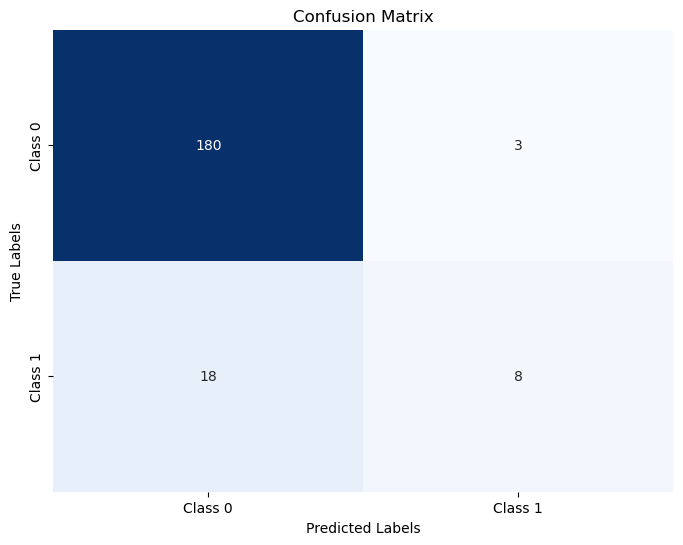

In [11]:
model_test(model1)

In [14]:
# RECALL

In [30]:
def custom_recall(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label = 1)
recall_scorer = make_scorer(custom_recall)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Time taken: 96.93479561805725 seconds
Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


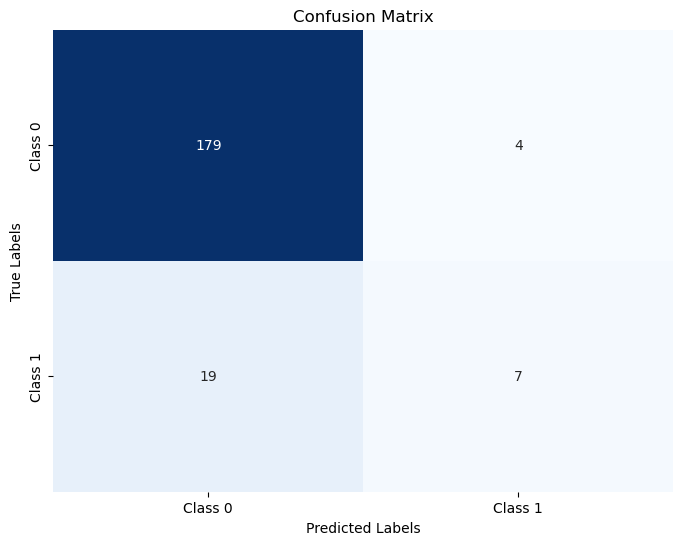

In [86]:
param_grid1 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params1, best_model1 = grid_searcher(param_grid1, model1, 'recall') # , best_params_list1
model_test(best_model1)
# best_models1 = []
# for param in best_params_list1:
#     print()
#     model = RFC(**param, random_state = 42)
#     print(model)
#     model.fit(X_nt_ov, y_nt_ov)
#     model_test(model, suppress_output = False)
#     best_models1.append(model)

In [87]:
# for i in np.arange(50, 251, 10):
#     param_grid1a = {
#         'n_estimators': [i],
#     }
#     best_params1a, best_model1a, best_params = grid_searcher(param_grid1a, model1, 'recall')
#     model_test(best_model1a)

In [36]:
grid_search = GridSearchCV(model1, param_grid1a, scoring = recall_scorer, cv = 10, verbose = 3)
grid_search.fit(X_nt_ov, y_nt_ov)

Fitting 10 folds for each of 21 candidates, totalling 210 fits
[CV 1/10] END ..................n_estimators=50;, score=1.000 total time=   0.1s
[CV 2/10] END ..................n_estimators=50;, score=1.000 total time=   0.1s
[CV 3/10] END ..................n_estimators=50;, score=1.000 total time=   0.1s
[CV 4/10] END ..................n_estimators=50;, score=1.000 total time=   0.1s
[CV 5/10] END ..................n_estimators=50;, score=1.000 total time=   0.1s
[CV 6/10] END ..................n_estimators=50;, score=1.000 total time=   0.1s
[CV 7/10] END ..................n_estimators=50;, score=1.000 total time=   0.1s
[CV 8/10] END ..................n_estimators=50;, score=1.000 total time=   0.1s
[CV 9/10] END ..................n_estimators=50;, score=1.000 total time=   0.1s
[CV 10/10] END .................n_estimators=50;, score=0.952 total time=   0.1s
[CV 1/10] END ..................n_estimators=60;, score=1.000 total time=   0.1s
[CV 2/10] END ..................n_estimators=6

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120,
                                          130, 140, 150, 160, 170, 180, 190,
                                          200, 210, 220, 230, 240, 250]},
             scoring=make_scorer(custom_recall, response_method='predict'),
             verbose=3)

In [37]:
grid_search.cv_results_

{'mean_fit_time': array([0.18556688, 0.1989012 , 0.23800132, 0.2676367 , 0.30647802,
        0.33605251, 0.37610343, 0.39126401, 0.42217038, 0.45995066,
        0.47566941, 0.50527604, 0.53541508, 0.56549942, 0.59731107,
        0.62898309, 0.65650876, 0.67918696, 0.71600835, 0.74937141,
        0.77914979]),
 'std_fit_time': array([0.01809907, 0.00757551, 0.01230524, 0.01270806, 0.01421114,
        0.00860189, 0.02500537, 0.00717213, 0.01311335, 0.03383477,
        0.01497912, 0.01253367, 0.01614814, 0.01069051, 0.01748611,
        0.01970813, 0.02050078, 0.01605974, 0.0177583 , 0.01673655,
        0.01159913]),
 'mean_score_time': array([0.01272986, 0.01165679, 0.01564701, 0.01491451, 0.01750488,
        0.02025483, 0.01810014, 0.02272332, 0.02247031, 0.02282796,
        0.02478859, 0.02674766, 0.02720654, 0.0266643 , 0.03101916,
        0.02879839, 0.03161683, 0.03373213, 0.03710151, 0.0574563 ,
        0.03371394]),
 'std_score_time': array([0.00264493, 0.0037716 , 0.00258301, 0.00

In [52]:
m = RFC()
m.n_estimators

100

In [53]:
m.n_estimators = 150
m.n_estimators

150

Fitting 10 folds for each of 51 candidates, totalling 510 fits
Time taken: 8.727477312088013 seconds
Best Hyperparameters: {'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


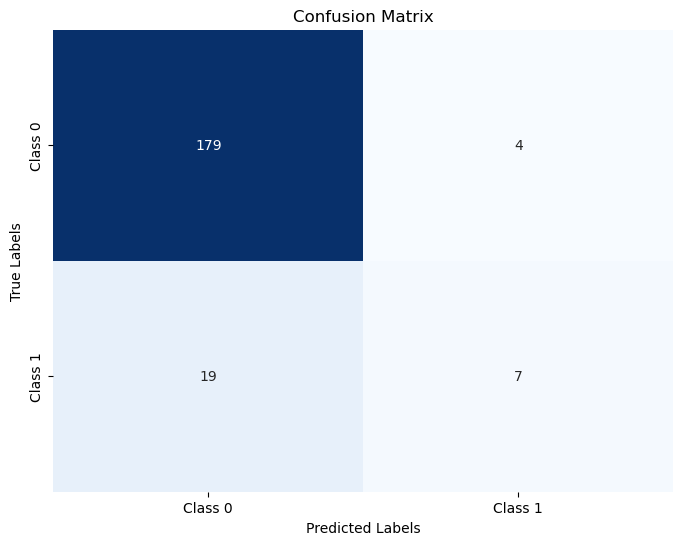

In [98]:
param_grid1a = {
    'n_estimators': list(np.arange(50, 101)),
}
best_params1a, best_model1a = grid_searcher(param_grid1a, model1, recall_scorer) # , best_params_list1a
model_test(best_model1a)
# print(best_params1a)
# best_models1a = []
# for param in best_params_list1a:
#     model = RFC(**param, random_state = 42)
#     model.fit(X_nt_ov, y_nt_ov)
#     model_test(model)
#     best_models1a.append(model)

In [48]:
model1

RandomForestClassifier(random_state=42)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Time taken: 0.9595334529876709 seconds
Best Hyperparameters: {'max_depth': None}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


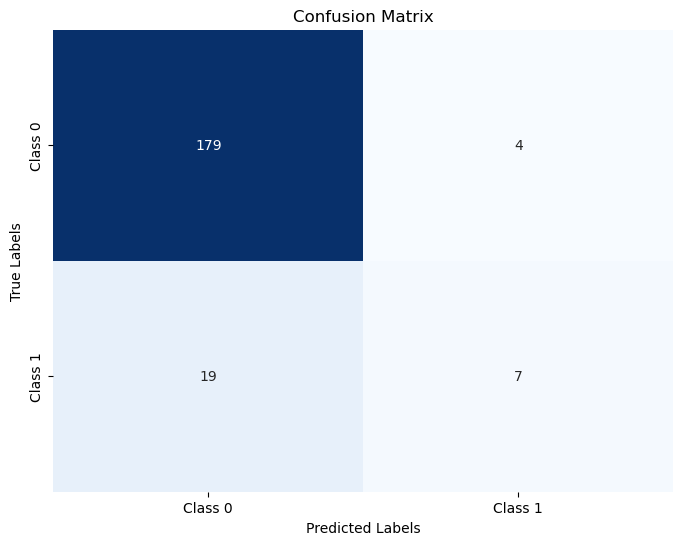

In [89]:
param_grid1ai = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
}
best_params1ai, best_model1ai = grid_searcher(param_grid1ai, best_model1a, 'recall') # , best_params_list1ai
model_test(best_model1ai)
# best_models1ai = []
# for param in best_params1ai:
#     print()
#     model = RFC(**param, random_state = 42)
#     print(model)
#     model.fit(X_nt_ov, y_nt_ov)
#     model_test(model, suppress_output = False)
#     best_models1ai.append(model)

Fitting 10 folds for each of 1377 candidates, totalling 13770 fits
Time taken: 219.56516098976135 seconds
Best Hyperparameters: {'max_depth': None, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


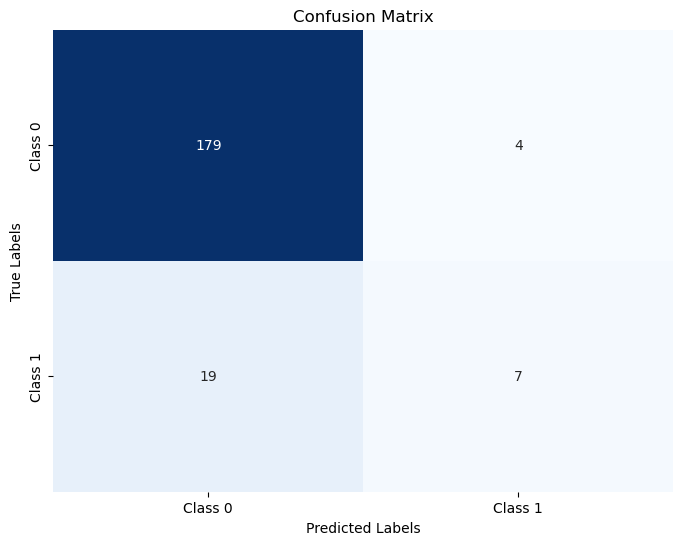

In [99]:
param_grid1b = {
    'n_estimators': list(np.arange(50, 101)),
    'max_depth': [None] + list(np.arange(5, 31)),
}
best_params1b, best_model1b = grid_searcher(param_grid1b, model1, 'recall') # , best_params_list1ai
model_test(best_model1b)

Fitting 10 folds for each of 45 candidates, totalling 450 fits
Time taken: 5.190714597702026 seconds
Best Hyperparameters: {'min_samples_leaf': 1, 'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


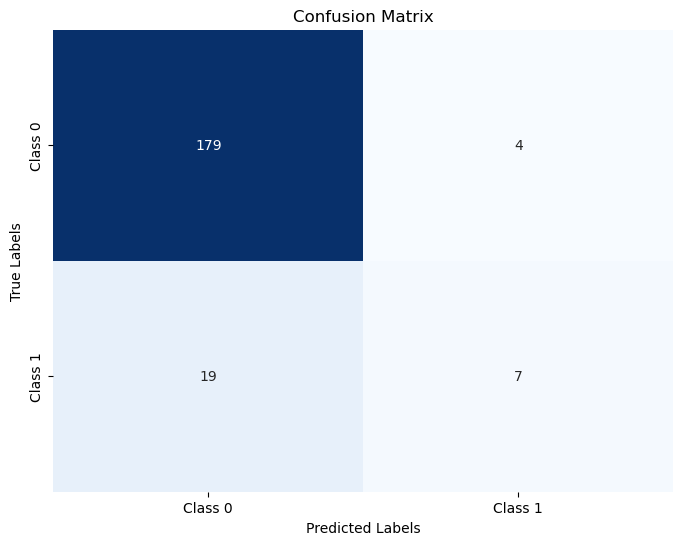

In [95]:
param_grid1aii = {
    'min_samples_split': list(np.arange(2, 11)),
    'min_samples_leaf': list(np.arange(1, 6)),
}
best_params1aii, best_model1aii = grid_searcher(param_grid1aii, best_model1ai, 'recall') # , best_params_list1ai
model_test(best_model1aii)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 1.8862583637237549 seconds
Best Hyperparameters: {'bootstrap': True, 'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.94       183
     Class 1       0.64      0.27      0.38        26

    accuracy                           0.89       209
   macro avg       0.77      0.62      0.66       209
weighted avg       0.87      0.89      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       179 |         4 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


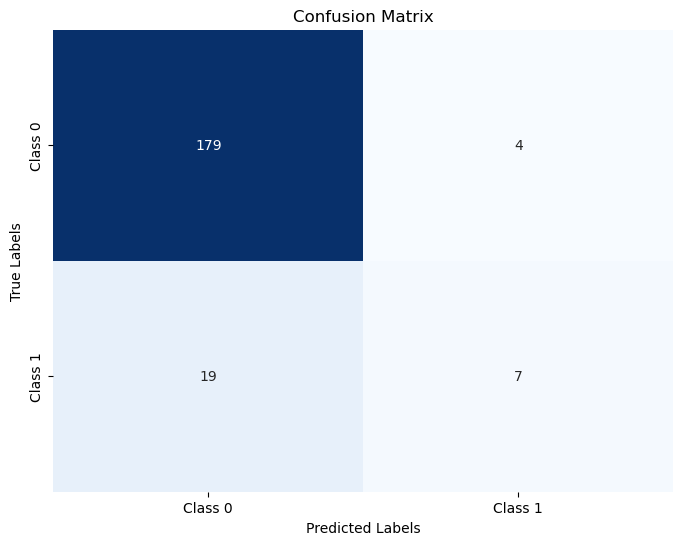

In [96]:
param_grid1aiii = {
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params1aiii, best_model1aiii = grid_searcher(param_grid1aiii, best_model1aii, 'recall')
model_test(best_model1aiii)

In [12]:
# param_grid1 = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2'],
#     'bootstrap': [True, False]
# }

In [100]:
# PRECISION

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Time taken: 168.12408447265625 seconds
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.88      0.27      0.41        26

    accuracy                           0.90       209
   macro avg       0.89      0.63      0.68       209
weighted avg       0.90      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


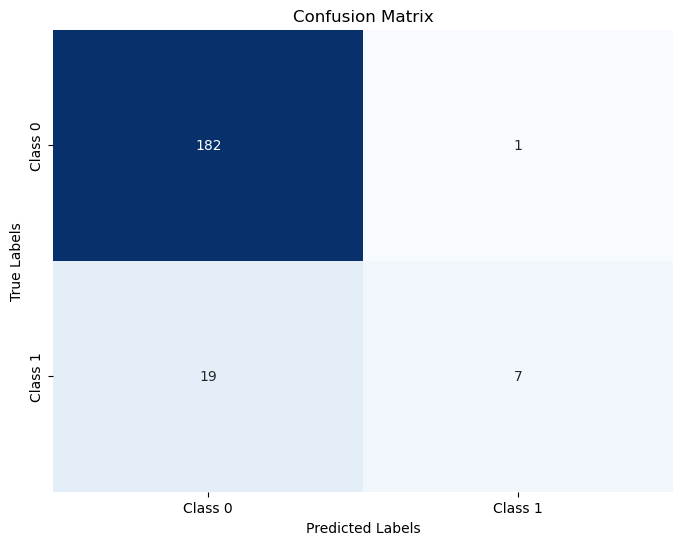

In [102]:
param_grid2 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params2, best_model2 = grid_searcher(param_grid2, model1, 'precision')
model_test(best_model2)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits
Time taken: 47.175878286361694 seconds
Best Hyperparameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.88      0.27      0.41        26

    accuracy                           0.90       209
   macro avg       0.89      0.63      0.68       209
weighted avg       0.90      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


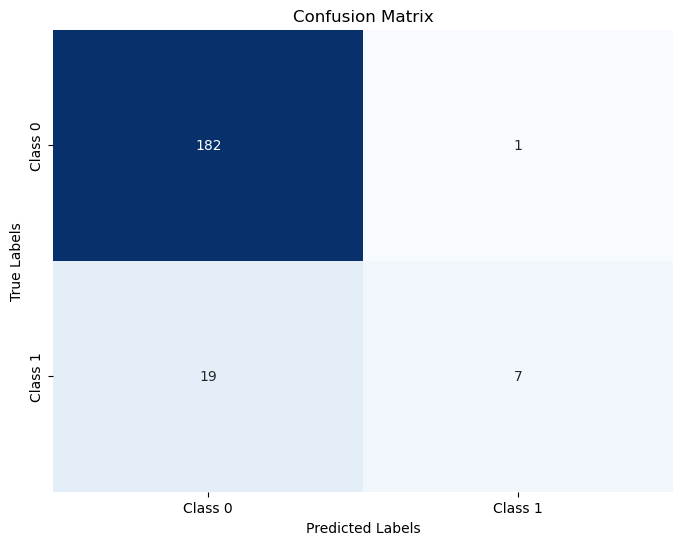

In [103]:
param_grid2a = {
    'n_estimators': [50, 75, 100],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 3, 4,],
    # 'min_samples_leaf': [1, 2, 4],
    'max_features': [0.5, 0.6, 0.7, 0.8, 'sqrt', 'log2'],
    # 'bootstrap': [True, False]
}
best_params2a, best_model2a = grid_searcher(param_grid2a, best_model2, 'precision')
model_test(best_model2a)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Time taken: 4.8236212730407715 seconds
Best Hyperparameters: {'n_estimators': 150}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


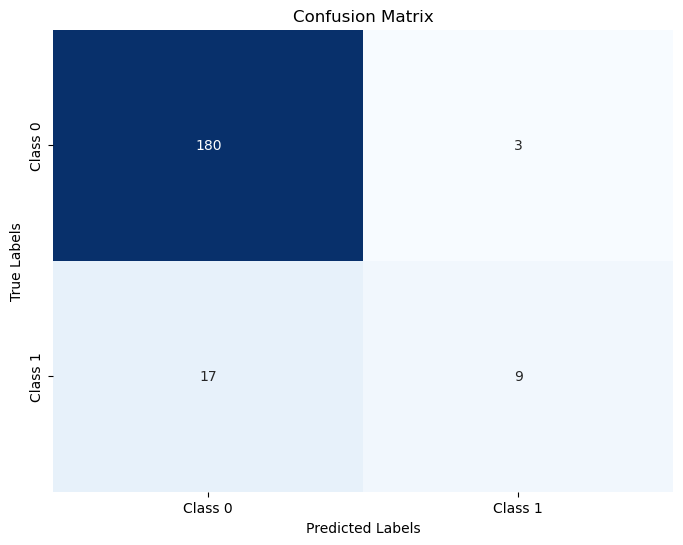

In [32]:
param_grid2a = {
    'n_estimators': list(np.arange(50, 201, 10)),
}
best_params2a, best_model2a = grid_searcher(param_grid2a, model1, 'precision')
model_test(best_model2a)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Time taken: 8.927165508270264 seconds
Best Hyperparameters: {'max_depth': 23}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


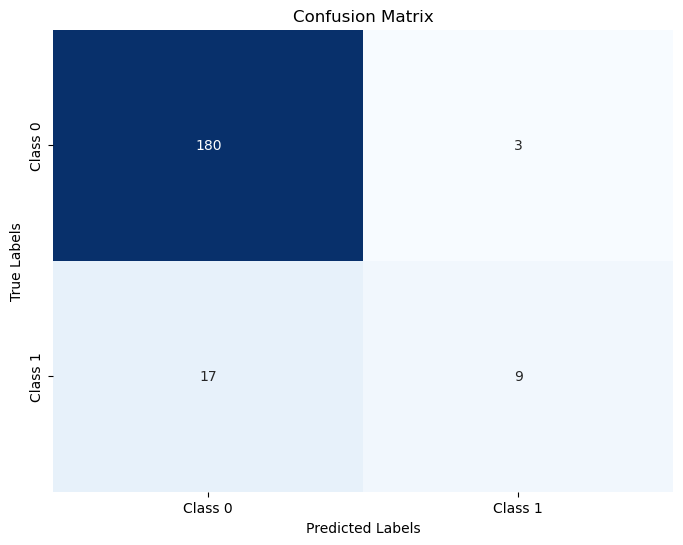

In [33]:
param_grid2ai = {
    'max_depth': [None] + list(np.arange(5, 31)),
}
best_params2ai, best_model2ai = grid_searcher(param_grid2ai, best_model2a, 'precision')
model_test(best_model2ai)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 4.743544340133667 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


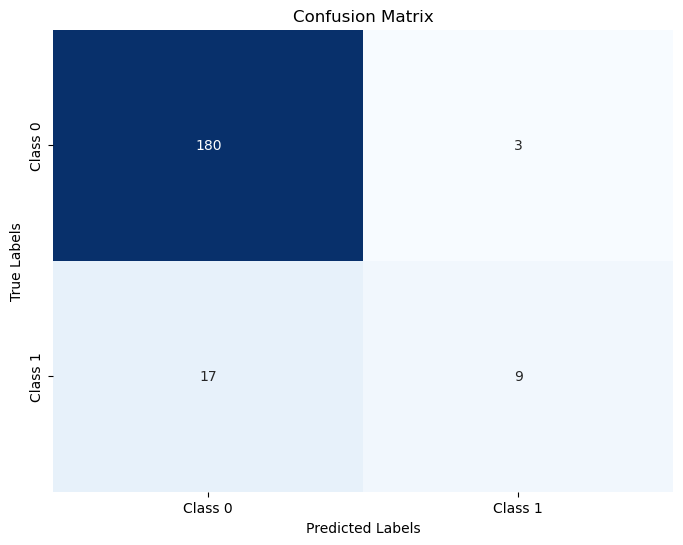

In [34]:
param_grid2aii = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params2aii, best_model2aii = grid_searcher(param_grid2aii, best_model2ai, 'precision')
model_test(best_model2aii)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.1186790466308594 seconds
Best Hyperparameters: {'bootstrap': False}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.99      0.94       183
     Class 1       0.80      0.15      0.26        26

    accuracy                           0.89       209
   macro avg       0.85      0.57      0.60       209
weighted avg       0.88      0.89      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        22 |         4 |
+-----------+-----------+


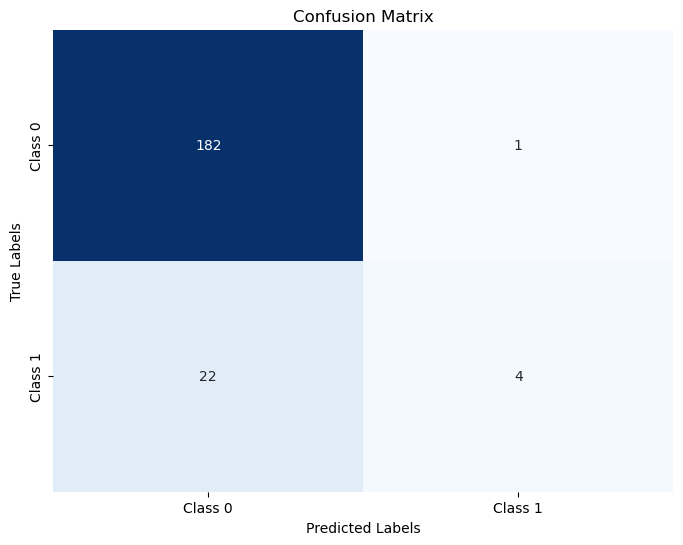

In [35]:
param_grid2aiii = {
    'bootstrap': [True, False]
}
best_params2aiii, best_model2aiii = grid_searcher(param_grid2aiii, best_model2aii, 'precision')
model_test(best_model2aiii)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 6.419929504394531 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.99      0.94       183
     Class 1       0.80      0.15      0.26        26

    accuracy                           0.89       209
   macro avg       0.85      0.57      0.60       209
weighted avg       0.88      0.89      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        22 |         4 |
+-----------+-----------+


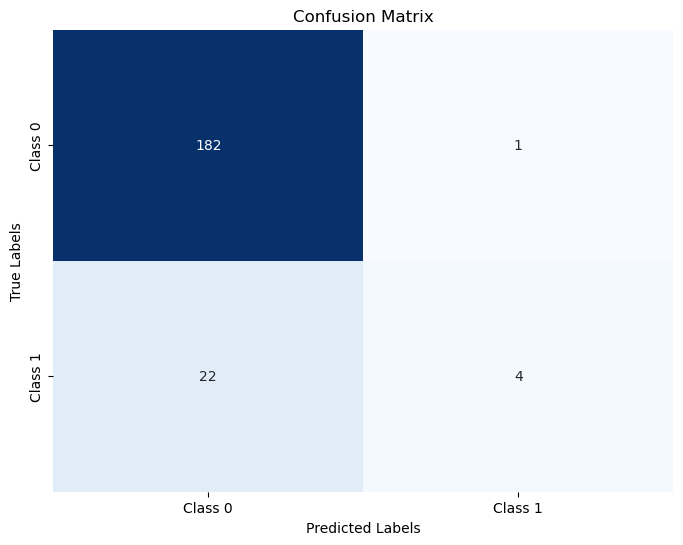

In [37]:
param_grid2aiv = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params2aiv, best_model2aiv = grid_searcher(param_grid2aiv, best_model2aiii, 'precision')
model_test(best_model2aiv)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 19.621047019958496 seconds
Best Hyperparameters: {'max_features': 'log2'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.99      0.95       183
     Class 1       0.86      0.23      0.36        26

    accuracy                           0.90       209
   macro avg       0.88      0.61      0.65       209
weighted avg       0.90      0.90      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


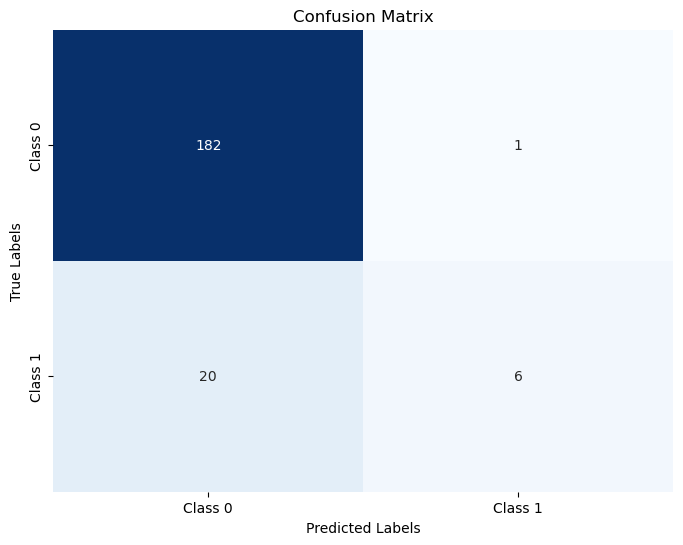

In [38]:
param_grid2av = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1.0, 0.01))
}
best_params2av, best_model2av = grid_searcher(param_grid2av, best_model2aiv, 'precision')
model_test(best_model2av)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.013535737991333 seconds
Best Hyperparameters: {'max_features': 'log2'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.99      0.95       183
     Class 1       0.86      0.23      0.36        26

    accuracy                           0.90       209
   macro avg       0.88      0.61      0.65       209
weighted avg       0.90      0.90      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


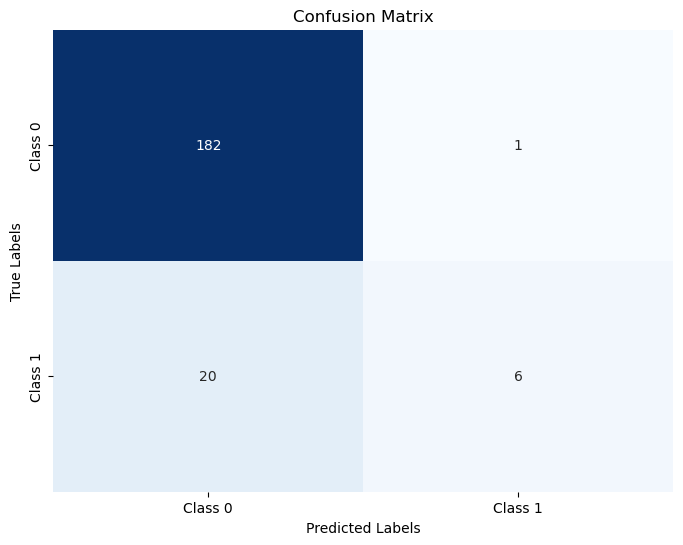

In [40]:
param_grid2av = {
    'max_features': ['sqrt', 'log2'] # + list(np.arange(0.5, 1.0, 0.01))
}
best_params2av, best_model2av = grid_searcher(param_grid2av, best_model2aiv, 'precision')
model_test(best_model2av)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Time taken: 0.7762224674224854 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


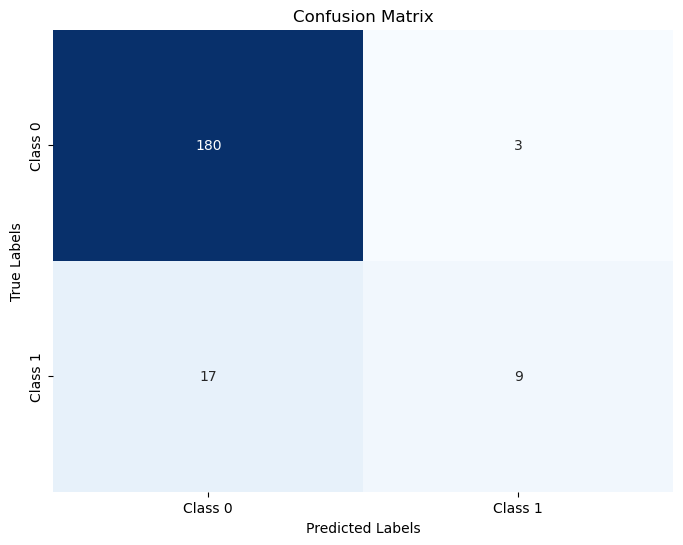

In [41]:
param_grid2aiii = {
    'bootstrap': [True]
}
best_params2aiii, best_model2aiii = grid_searcher(param_grid2aiii, best_model2aii, 'precision')
model_test(best_model2aiii)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 3.5127041339874268 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


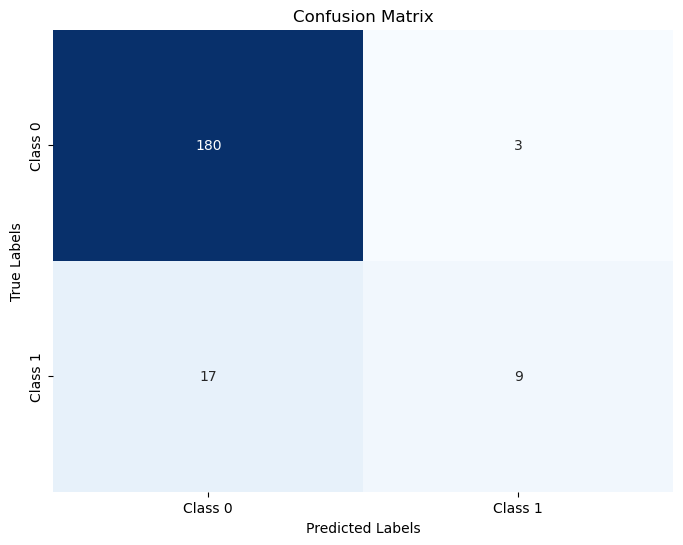

In [42]:
param_grid2aiv = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params2aiv, best_model2aiv = grid_searcher(param_grid2aiv, best_model2aiii, 'precision')
model_test(best_model2aiv)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 19.48006844520569 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


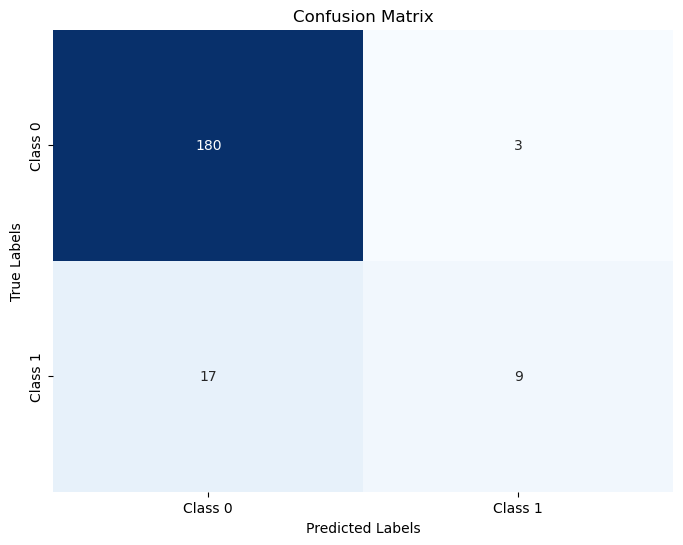

In [43]:
param_grid2av = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1.0, 0.01))
}
best_params2av, best_model2av = grid_searcher(param_grid2av, best_model2aiv, 'precision')
model_test(best_model2av)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.2032010555267334 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


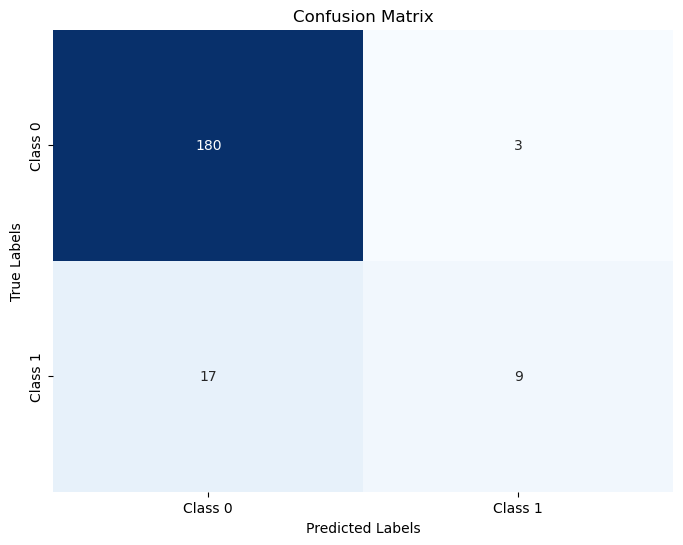

In [44]:
param_grid2av = {
    'max_features': ['sqrt', 'log2'] # + list(np.arange(0.5, 1.0, 0.01))
}
best_params2av, best_model2av = grid_searcher(param_grid2av, best_model2aiv, 'precision')
model_test(best_model2av)

In [104]:
# F1

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Time taken: 125.35021209716797 seconds
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.88      0.27      0.41        26

    accuracy                           0.90       209
   macro avg       0.89      0.63      0.68       209
weighted avg       0.90      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


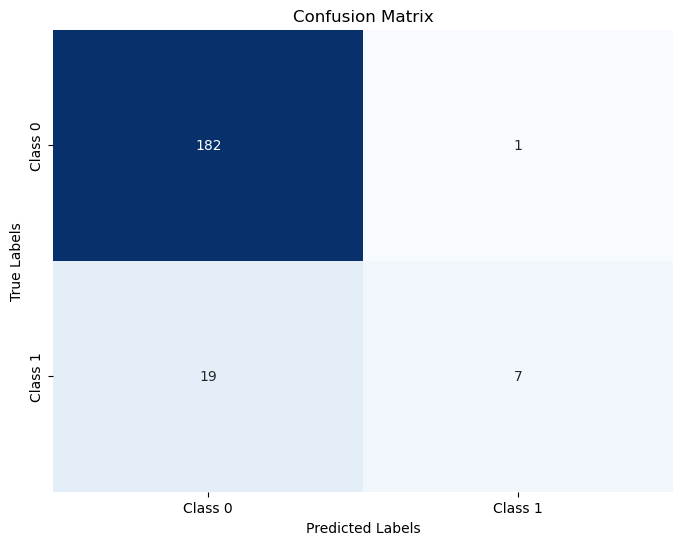

In [184]:
param_grid3 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params3, best_model3 = grid_searcher(param_grid3, model1, 'f1')
model_test(best_model3)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Time taken: 12.112831592559814 seconds
Best Hyperparameters: {'n_estimators': 150}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


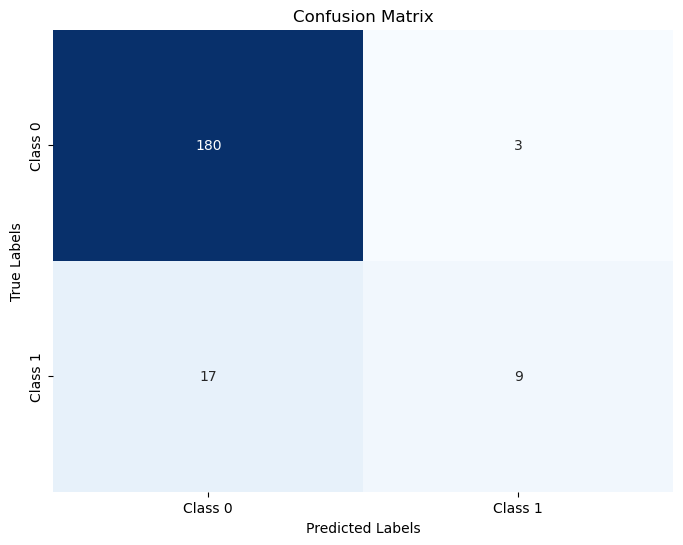

In [14]:
param_grid3a = {
    'n_estimators': list(np.arange(50, 201, 10)),
}
best_params3a, best_model3a = grid_searcher(param_grid3a, model1, 'f1')
model_test(best_model3a)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Time taken: 14.882806062698364 seconds
Best Hyperparameters: {'max_depth': 23}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


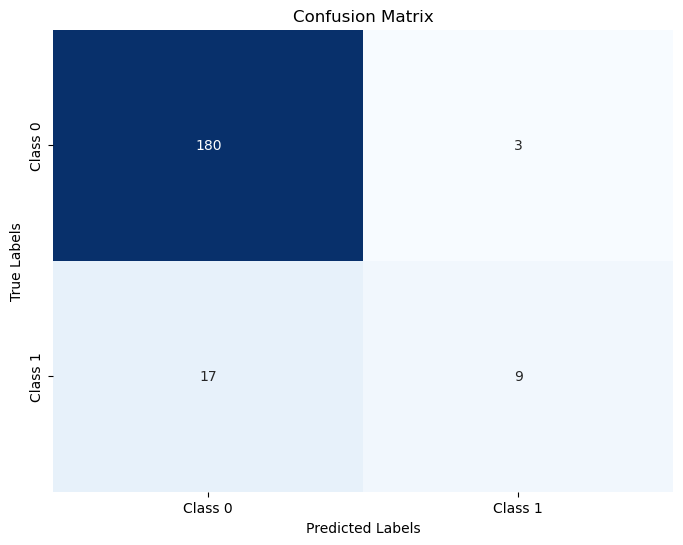

In [15]:
param_grid3ai = {
    'max_depth': [None] + list(np.arange(5, 31)),
}
best_params3ai, best_model3ai = grid_searcher(param_grid3ai, best_model3a, 'f1')
model_test(best_model3ai)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 8.140504598617554 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


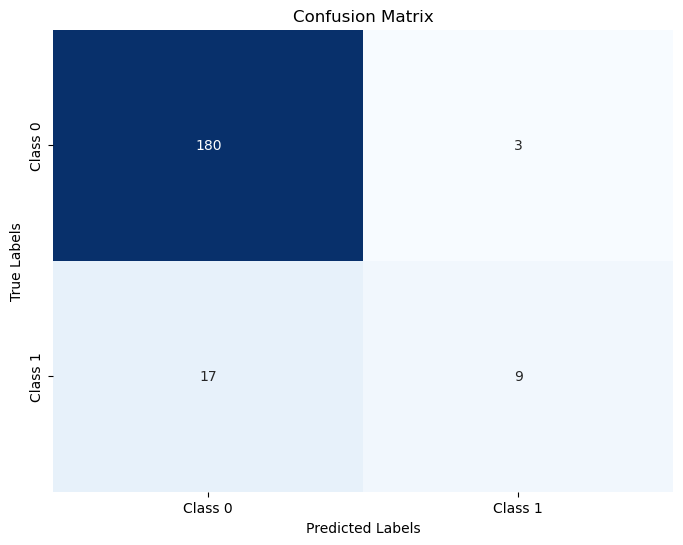

In [16]:
param_grid3aii = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params3aii, best_model3aii = grid_searcher(param_grid3aii, best_model3ai, 'f1')
model_test(best_model3aii)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.9116601943969727 seconds
Best Hyperparameters: {'bootstrap': False}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.99      0.94       183
     Class 1       0.80      0.15      0.26        26

    accuracy                           0.89       209
   macro avg       0.85      0.57      0.60       209
weighted avg       0.88      0.89      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        22 |         4 |
+-----------+-----------+


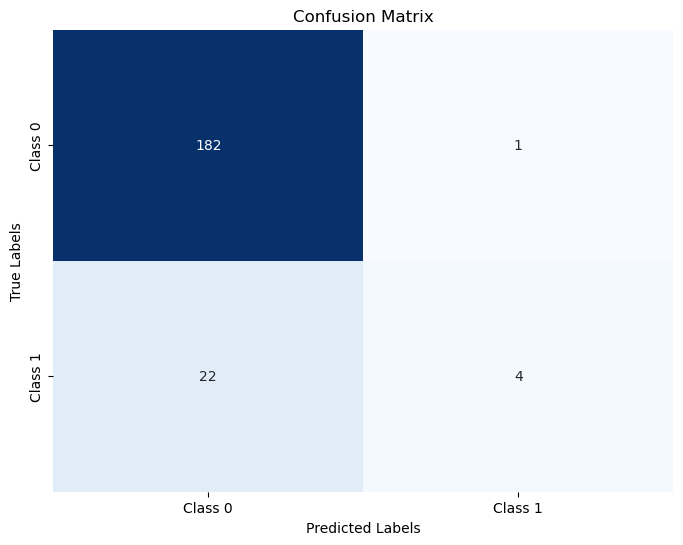

In [23]:
param_grid3aiii = {
    'bootstrap': [True, False]
}
best_params3aiii, best_model3aiii = grid_searcher(param_grid3aiii, best_model3aii, 'f1')
model_test(best_model3aiii)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 4.908367395401001 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.99      0.94       183
     Class 1       0.80      0.15      0.26        26

    accuracy                           0.89       209
   macro avg       0.85      0.57      0.60       209
weighted avg       0.88      0.89      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        22 |         4 |
+-----------+-----------+


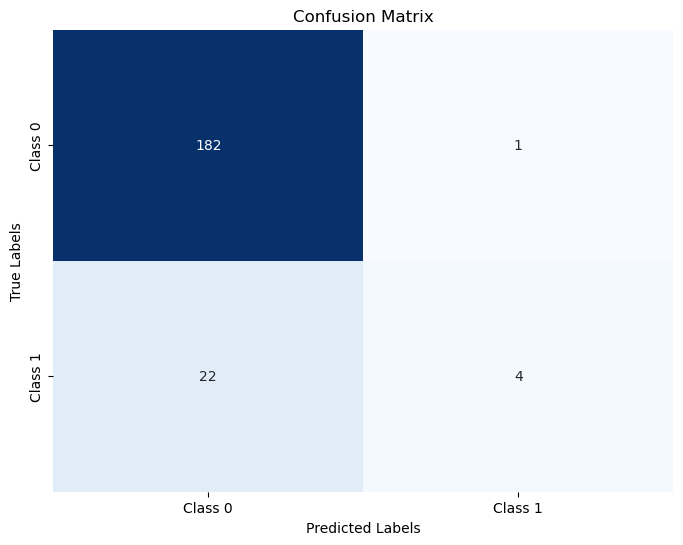

In [24]:
param_grid3aiv = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params3aiv, best_model3aiv = grid_searcher(param_grid3aiv, best_model3aiii, 'f1')
model_test(best_model3aiv)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 36.55487608909607 seconds
Best Hyperparameters: {'max_features': 'log2'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.99      0.95       183
     Class 1       0.86      0.23      0.36        26

    accuracy                           0.90       209
   macro avg       0.88      0.61      0.65       209
weighted avg       0.90      0.90      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


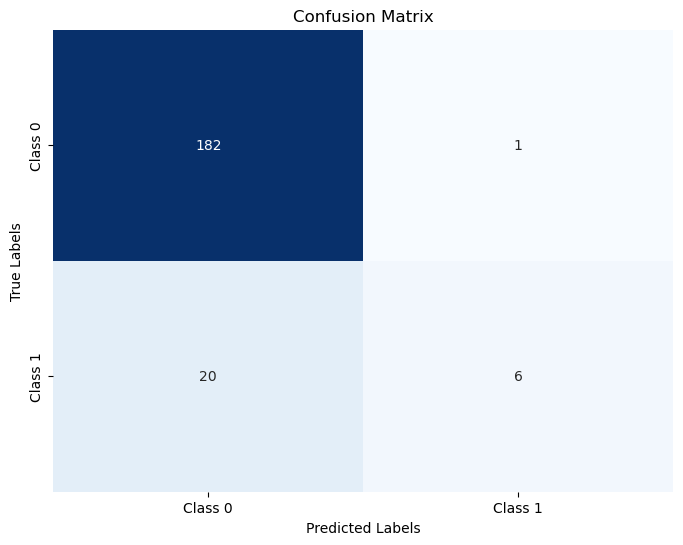

In [25]:
param_grid3av = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1.0, 0.01))
}
best_params3av, best_model3av = grid_searcher(param_grid3av, best_model3aiv, 'f1')
model_test(best_model3av)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.8222801685333252 seconds
Best Hyperparameters: {'max_features': 'log2'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.99      0.95       183
     Class 1       0.86      0.23      0.36        26

    accuracy                           0.90       209
   macro avg       0.88      0.61      0.65       209
weighted avg       0.90      0.90      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


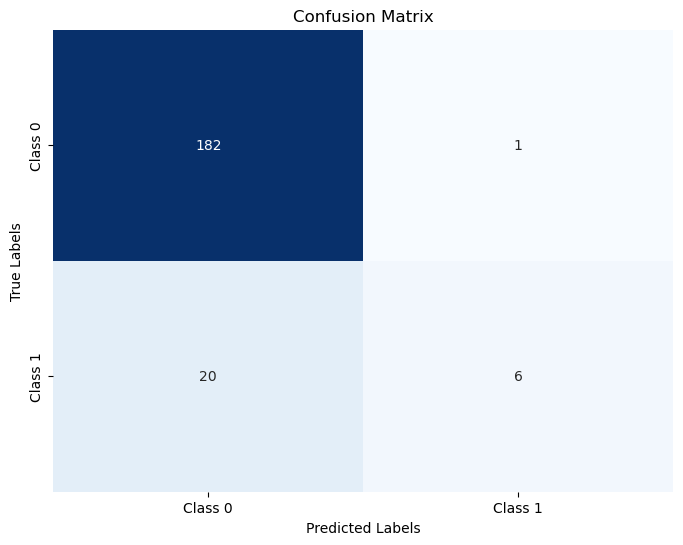

In [26]:
param_grid3av = {
    'max_features': ['sqrt', 'log2'] # + list(np.arange(0.5, 1.0, 0.01))
}
best_params3av, best_model3av = grid_searcher(param_grid3av, best_model3aiv, 'f1')
model_test(best_model3av)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Time taken: 0.8340902328491211 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


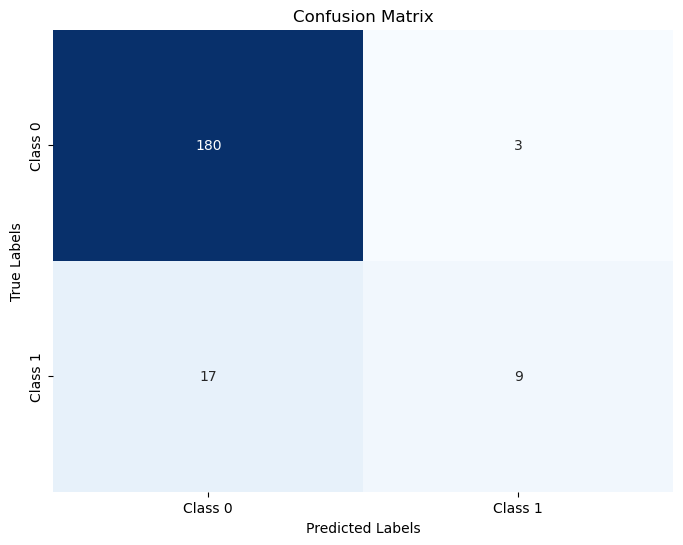

In [29]:
param_grid3aiii = {
    'bootstrap': [True] # , False]
}
best_params3aiii, best_model3aiii = grid_searcher(param_grid3aiii, best_model3aii, 'f1')
model_test(best_model3aiii)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 3.608332633972168 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


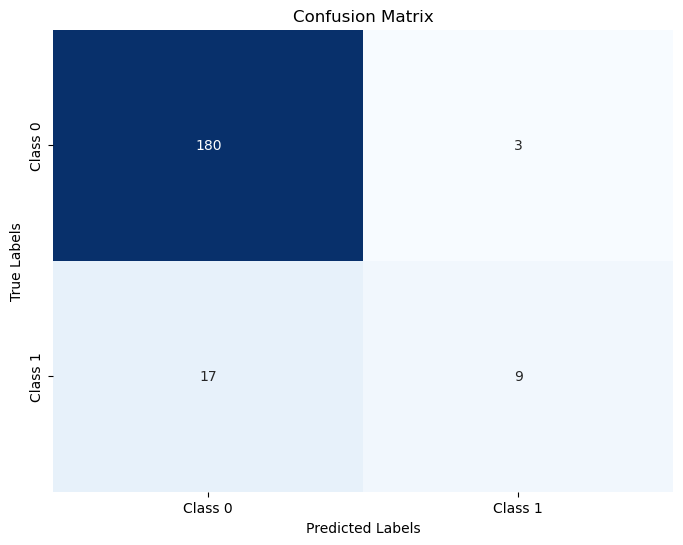

In [30]:
param_grid3aiv = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params3aiv, best_model3aiv = grid_searcher(param_grid3aiv, best_model3aiii, 'f1')
model_test(best_model3aiv)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.2158105373382568 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


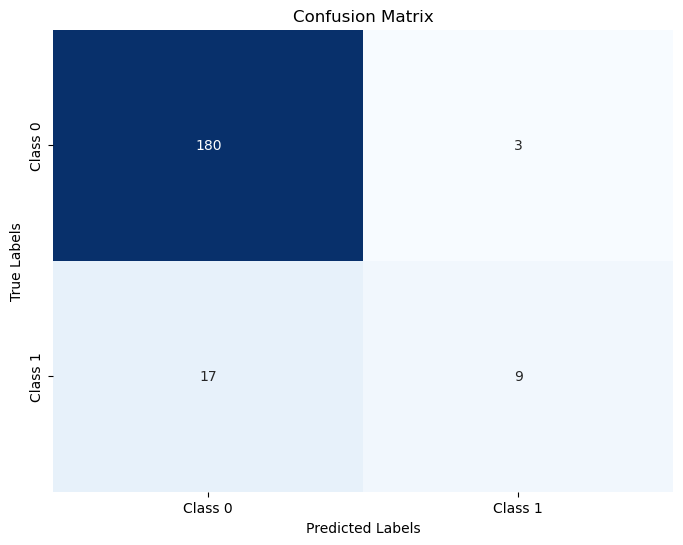

In [31]:
param_grid3av = {
    'max_features': ['sqrt', 'log2'] # + list(np.arange(0.5, 1.0, 0.01))
}
best_params3av, best_model3av = grid_searcher(param_grid3av, best_model3aiv, 'f1')
model_test(best_model3av)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 28.51333498954773 seconds
Best Hyperparameters: {'max_features': 'log2'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.99      0.95       183
     Class 1       0.86      0.23      0.36        26

    accuracy                           0.90       209
   macro avg       0.88      0.61      0.65       209
weighted avg       0.90      0.90      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


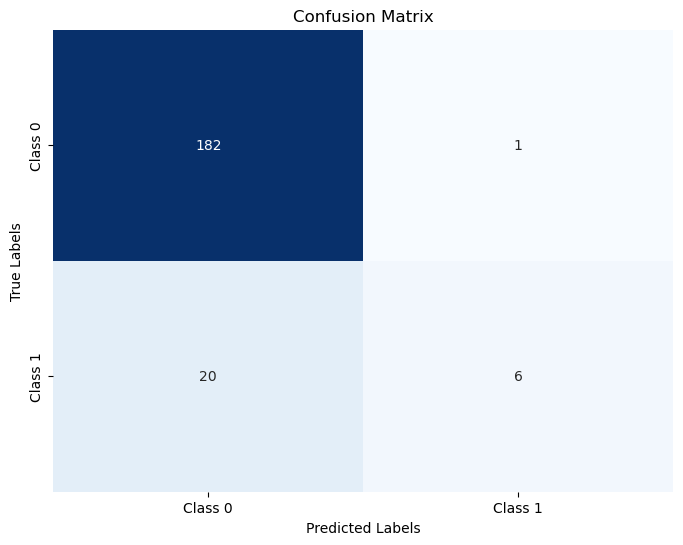

In [28]:
param_grid3av = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1.0, 0.01))
}
best_params3av, best_model3av = grid_searcher(param_grid3av, best_model3aiv, 'f1')
model_test(best_model3av)

In [108]:
# ROC_AUC

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Time taken: 98.56651973724365 seconds
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.99      0.94       183
     Class 1       0.83      0.19      0.31        26

    accuracy                           0.89       209
   macro avg       0.86      0.59      0.63       209
weighted avg       0.89      0.89      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


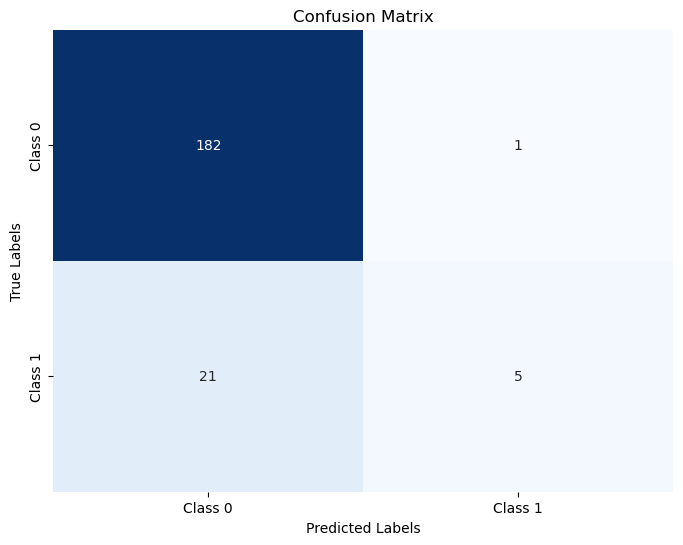

In [109]:
param_grid4 = {
    'n_estimators': [50, 70, 80],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params4, best_model4 = grid_searcher(param_grid4, model1, 'roc_auc')
model_test(best_model4)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Time taken: 12.373471975326538 seconds
Best Hyperparameters: {'n_estimators': 110}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.82      0.35      0.49        26

    accuracy                           0.91       209
   macro avg       0.87      0.67      0.72       209
weighted avg       0.90      0.91      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


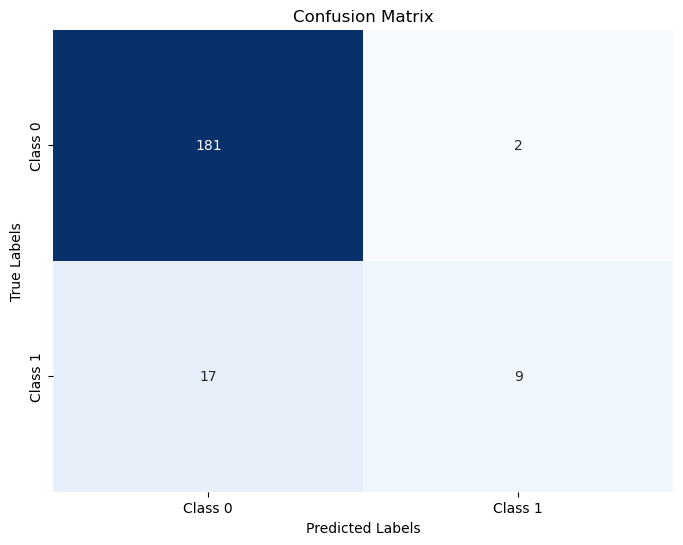

In [167]:
param_grid4a = {
    'n_estimators': list(np.arange(50, 201, 10)),
}
best_params4a, best_model4a = grid_searcher(param_grid4a, model1, 'roc_auc')
model_test(best_model4a)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Time taken: 11.478520631790161 seconds
Best Hyperparameters: {'max_depth': 21}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


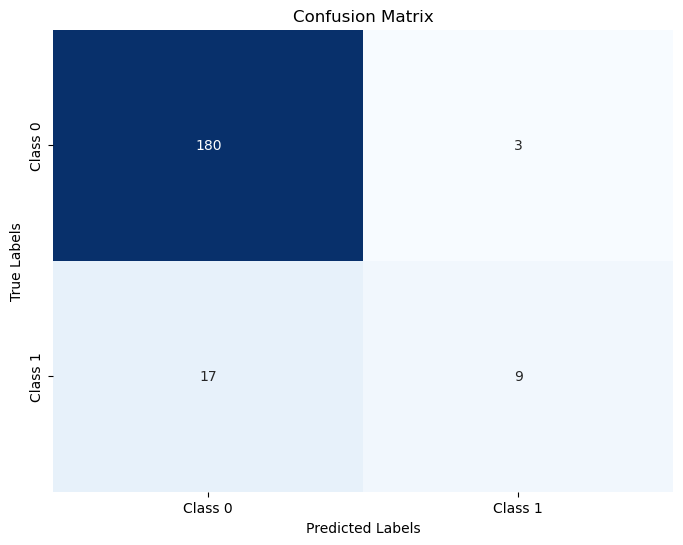

In [171]:
param_grid4ai = {
    'max_depth': [None] + list(np.arange(5, 31)),
}
best_params4ai, best_model4ai = grid_searcher(param_grid4ai, best_model4a, 'roc_auc')
model_test(best_model4ai)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 6.249980688095093 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


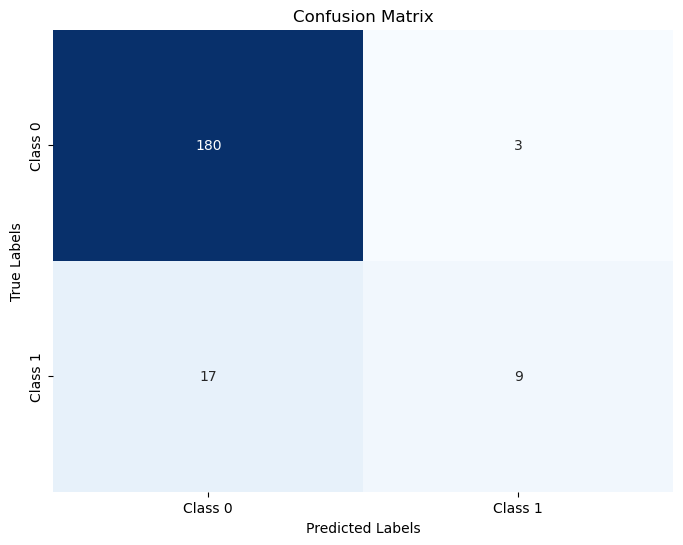

In [172]:
param_grid4aii = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params4aii, best_model4aii = grid_searcher(param_grid4aii, best_model4ai, 'roc_auc')
model_test(best_model4aii)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.5736618041992188 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


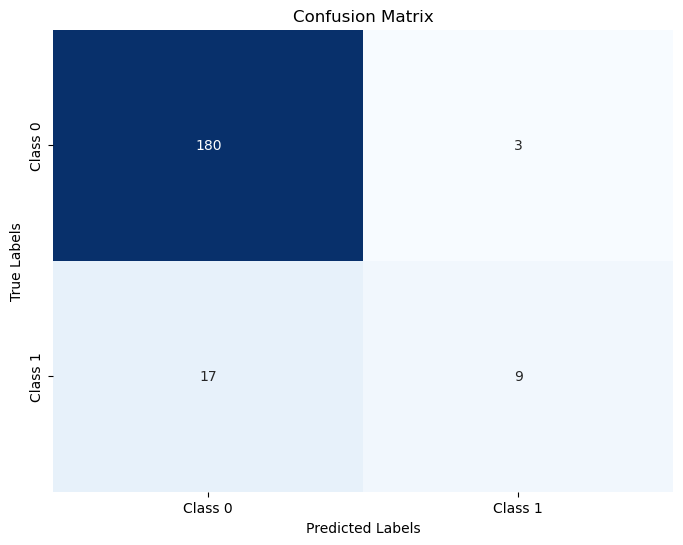

In [173]:
param_grid4aiii = {
    'bootstrap': [True, False]
}
best_params4aiii, best_model4aiii = grid_searcher(param_grid4aiii, best_model4aii, 'roc_auc')
model_test(best_model4aiii)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 4.679677963256836 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


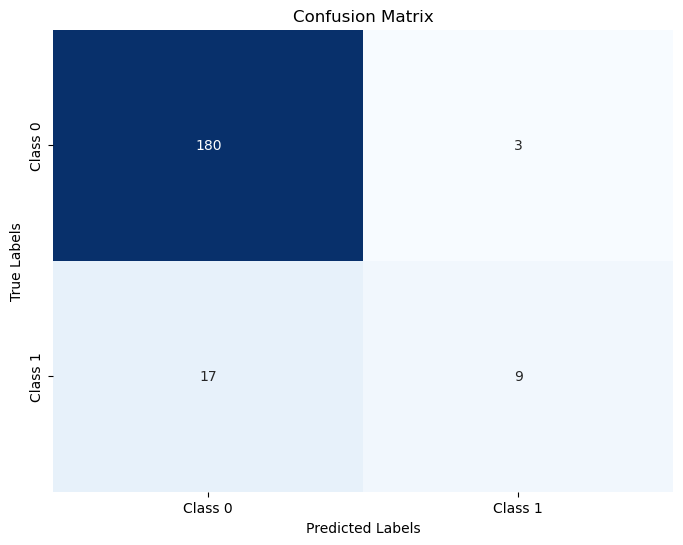

In [174]:
param_grid4aiv = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params4aiv, best_model4aiv = grid_searcher(param_grid4aiv, best_model4aiii, 'roc_auc')
model_test(best_model4aiv)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.7264411449432373 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


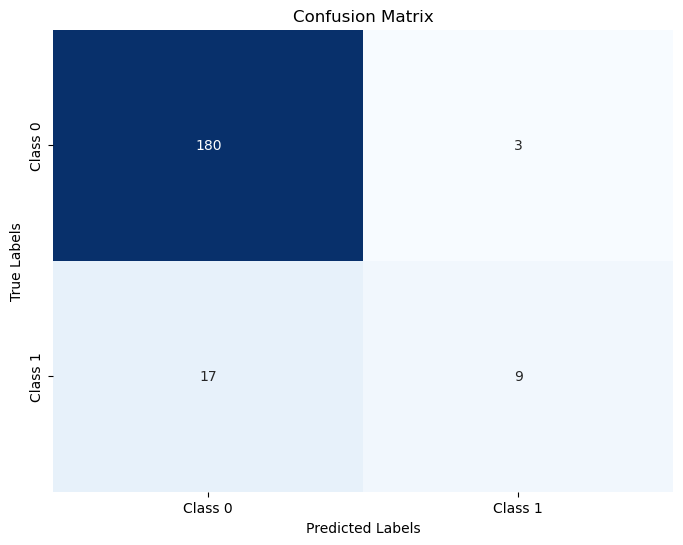

In [177]:
param_grid4av = {
    'max_features': ['sqrt', 'log2'] # + list(np.arange(0.5, 1.0, 0.01))
}
best_params4av, best_model4av = grid_searcher(param_grid4av, best_model4aiv, 'roc_auc')
model_test(best_model4av)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Time taken: 1.0808868408203125 seconds
Best Hyperparameters: {'max_depth': None}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.82      0.35      0.49        26

    accuracy                           0.91       209
   macro avg       0.87      0.67      0.72       209
weighted avg       0.90      0.91      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


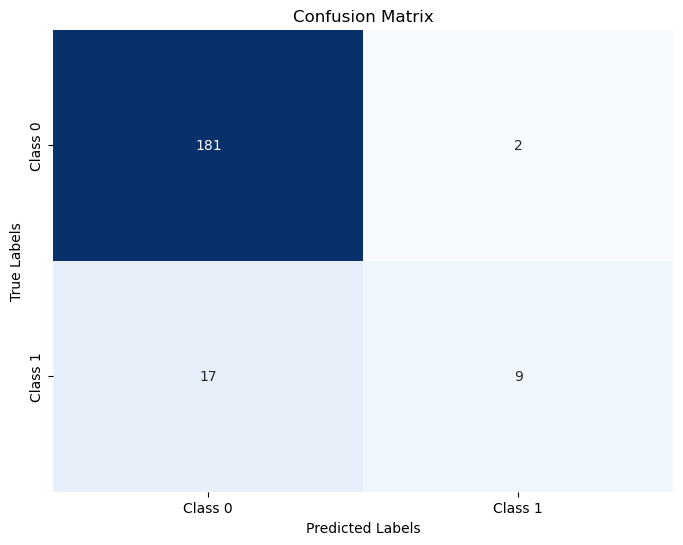

In [178]:
param_grid4ai = {
    'max_depth': [None] # + list(np.arange(5, 31)),
}
best_params4ai, best_model4ai = grid_searcher(param_grid4ai, best_model4a, 'roc_auc')
model_test(best_model4ai)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 6.47476601600647 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.82      0.35      0.49        26

    accuracy                           0.91       209
   macro avg       0.87      0.67      0.72       209
weighted avg       0.90      0.91      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


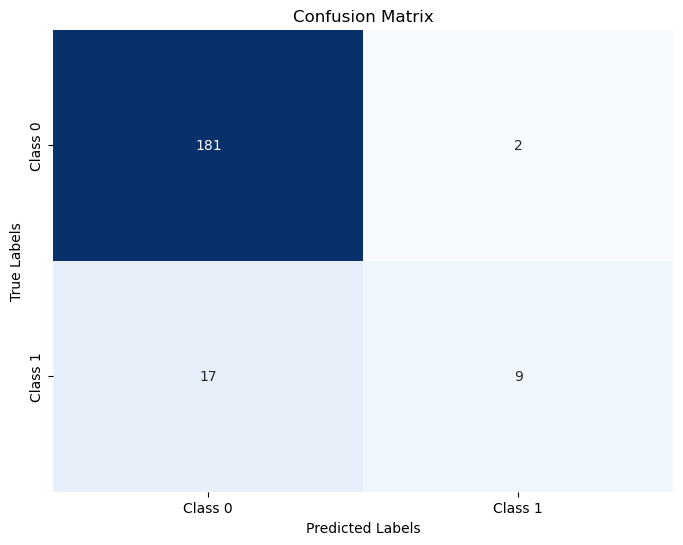

In [179]:
param_grid4aii = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params4aii, best_model4aii = grid_searcher(param_grid4aii, best_model4ai, 'roc_auc')
model_test(best_model4aii)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.573119878768921 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.82      0.35      0.49        26

    accuracy                           0.91       209
   macro avg       0.87      0.67      0.72       209
weighted avg       0.90      0.91      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


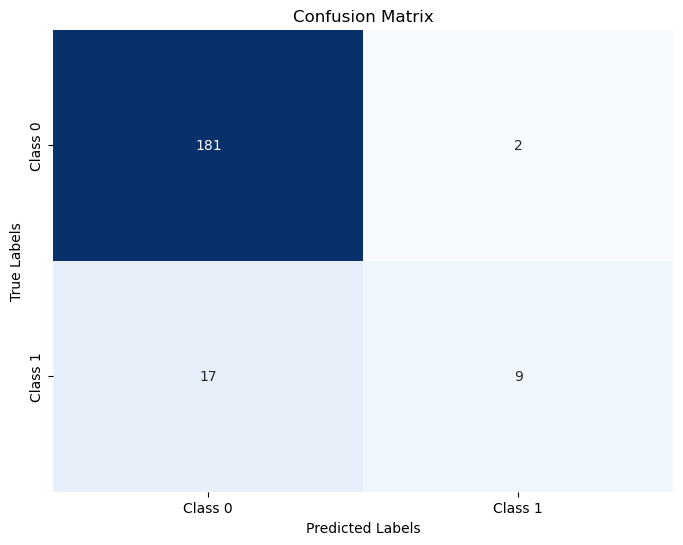

In [180]:
param_grid4aiii = {
    'bootstrap': [True, False]
}
best_params4aiii, best_model4aiii = grid_searcher(param_grid4aiii, best_model4aii, 'roc_auc')
model_test(best_model4aiii)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 4.7753071784973145 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.82      0.35      0.49        26

    accuracy                           0.91       209
   macro avg       0.87      0.67      0.72       209
weighted avg       0.90      0.91      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


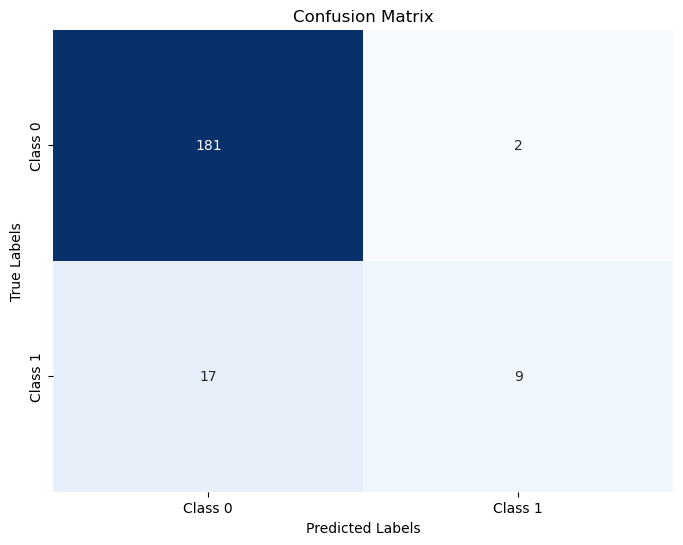

In [181]:
param_grid4aiv = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params4aiv, best_model4aiv = grid_searcher(param_grid4aiv, best_model4aiii, 'roc_auc')
model_test(best_model4aiv)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 27.225627899169922 seconds
Best Hyperparameters: {'max_features': 0.6000000000000001}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.95      0.93       183
     Class 1       0.44      0.27      0.33        26

    accuracy                           0.87       209
   macro avg       0.67      0.61      0.63       209
weighted avg       0.84      0.87      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       174 |         9 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


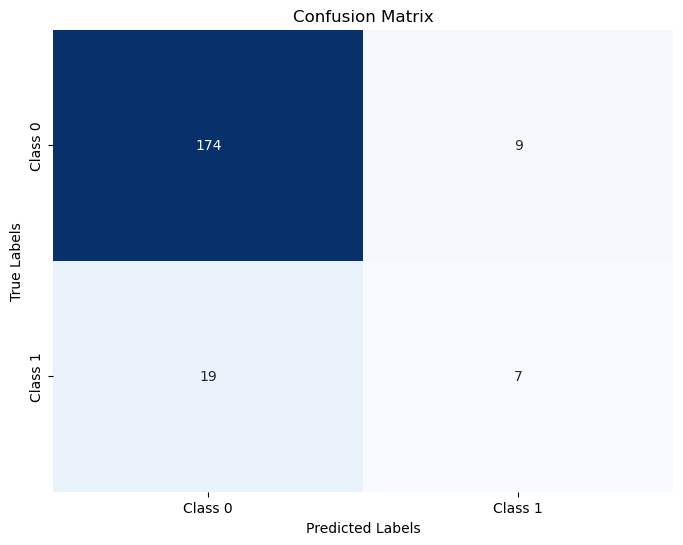

In [182]:
param_grid4av = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1.0, 0.01))
}
best_params4av, best_model4av = grid_searcher(param_grid4av, best_model4aiv, 'roc_auc')
model_test(best_model4av)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.6749508380889893 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.82      0.35      0.49        26

    accuracy                           0.91       209
   macro avg       0.87      0.67      0.72       209
weighted avg       0.90      0.91      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


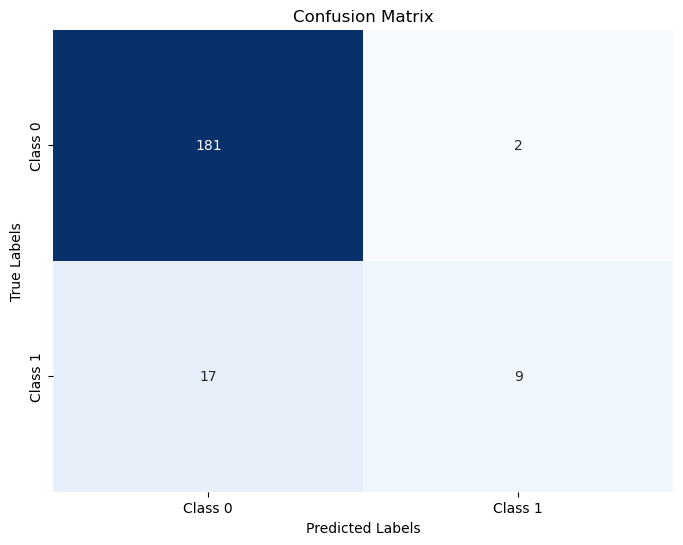

In [183]:
param_grid4av = {
    'max_features': ['sqrt', 'log2'] # + list(np.arange(0.5, 1.0, 0.01))
}
best_params4av, best_model4av = grid_searcher(param_grid4av, best_model4aiv, 'roc_auc')
model_test(best_model4av)

In [110]:
# MATTHEWS_CORRCOEF

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Time taken: 89.97475481033325 seconds
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.88      0.27      0.41        26

    accuracy                           0.90       209
   macro avg       0.89      0.63      0.68       209
weighted avg       0.90      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


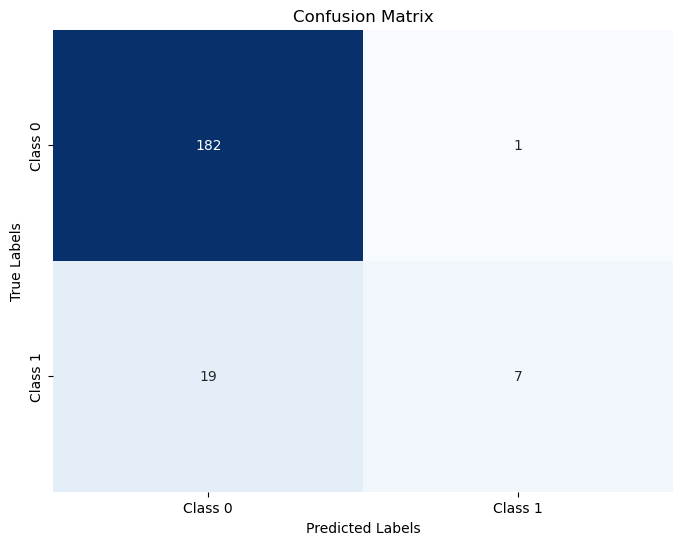

In [111]:
param_grid5 = {
    'n_estimators': [50, 70, 80],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params5, best_model5 = grid_searcher(param_grid5, model1, 'matthews_corrcoef')
model_test(best_model5)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Time taken: 8.29728078842163 seconds
Best Hyperparameters: {'n_estimators': 150}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


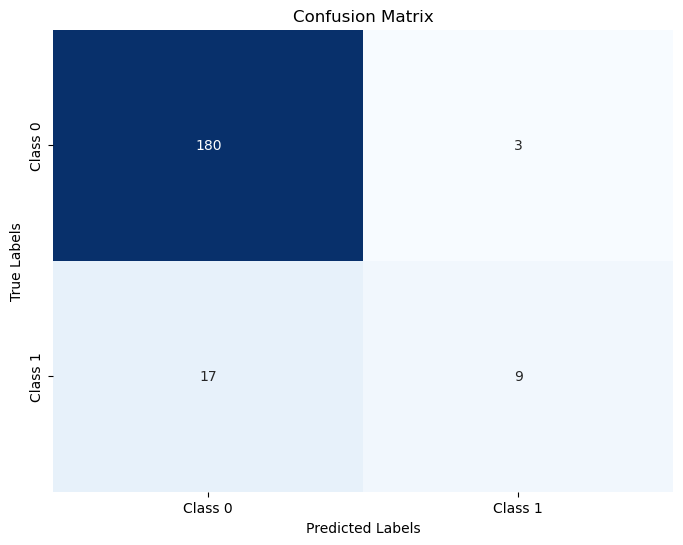

In [154]:
param_grid5a = {
    'n_estimators': list(np.arange(50, 201, 10)),
}
best_params5a, best_model5a = grid_searcher(param_grid5a, model1, 'matthews_corrcoef')
model_test(best_model5a)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Time taken: 14.704047679901123 seconds
Best Hyperparameters: {'max_depth': 23}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


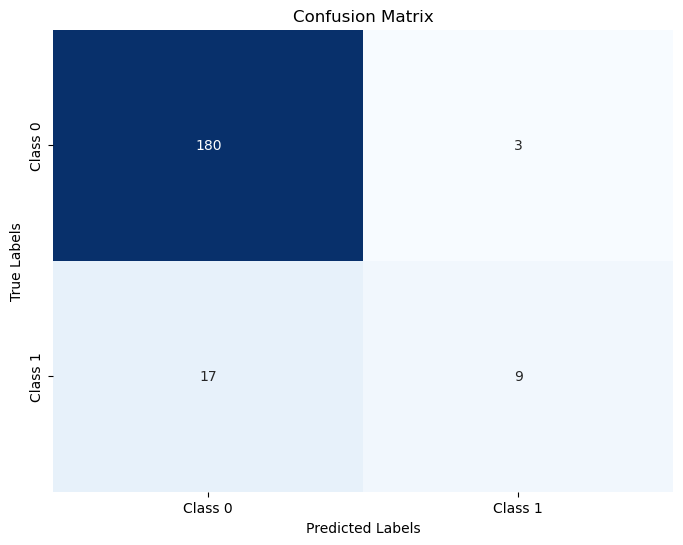

In [155]:
param_grid5ai = {
    'max_depth': [None] + list(np.arange(5, 31)),
}
best_params5ai, best_model5ai = grid_searcher(param_grid5ai, best_model5a, 'matthews_corrcoef')
model_test(best_model5ai)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 9.272593021392822 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


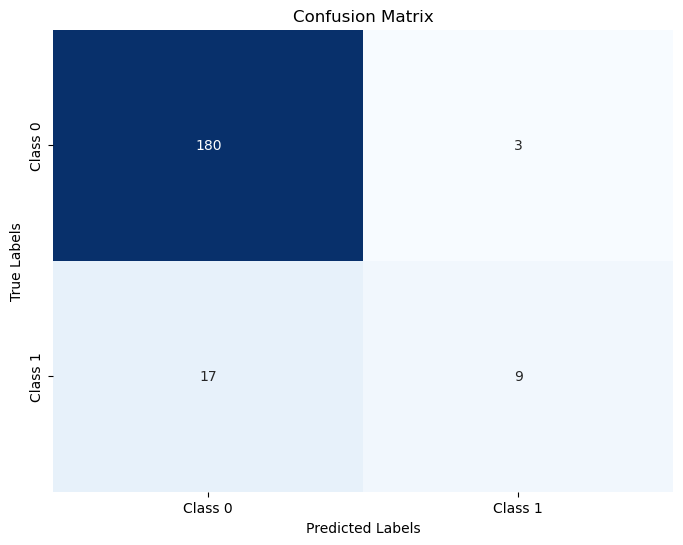

In [156]:
param_grid5aii = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params5aii, best_model5aii = grid_searcher(param_grid5aii, best_model5ai, 'matthews_corrcoef')
model_test(best_model5aii)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.900367259979248 seconds
Best Hyperparameters: {'bootstrap': False}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.99      0.94       183
     Class 1       0.80      0.15      0.26        26

    accuracy                           0.89       209
   macro avg       0.85      0.57      0.60       209
weighted avg       0.88      0.89      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        22 |         4 |
+-----------+-----------+


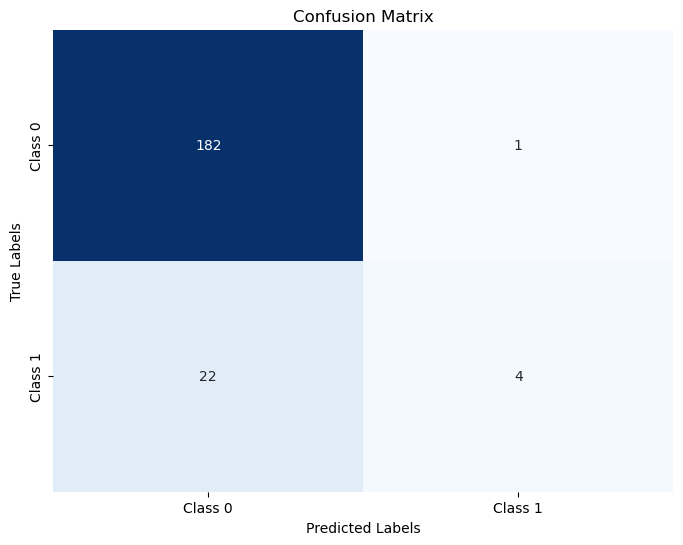

In [157]:
param_grid5aiii = {
    'bootstrap': [True, False]
}
best_params5aiii, best_model5aiii = grid_searcher(param_grid5aiii, best_model5aii, 'matthews_corrcoef')
model_test(best_model5aiii)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 5.037288665771484 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.99      0.94       183
     Class 1       0.80      0.15      0.26        26

    accuracy                           0.89       209
   macro avg       0.85      0.57      0.60       209
weighted avg       0.88      0.89      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        22 |         4 |
+-----------+-----------+


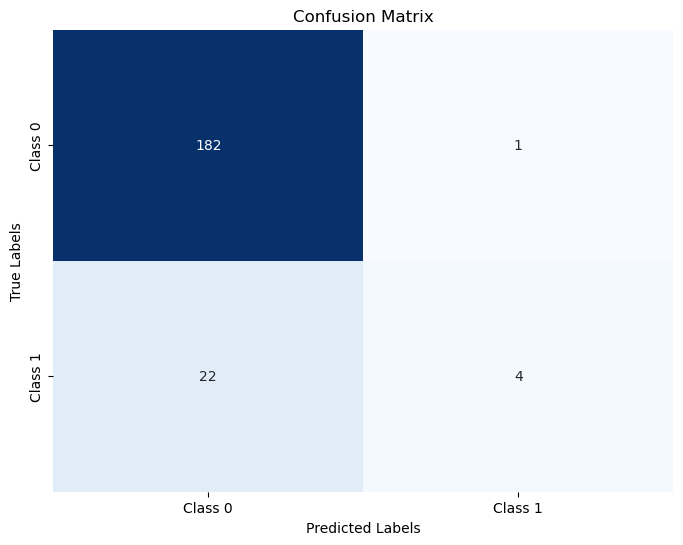

In [158]:
param_grid5aiv = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params5aiv, best_model5aiv = grid_searcher(param_grid5aiv, best_model5aiii, 'matthews_corrcoef')
model_test(best_model5aiv)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 34.40995478630066 seconds
Best Hyperparameters: {'max_features': 'log2'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.99      0.95       183
     Class 1       0.86      0.23      0.36        26

    accuracy                           0.90       209
   macro avg       0.88      0.61      0.65       209
weighted avg       0.90      0.90      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


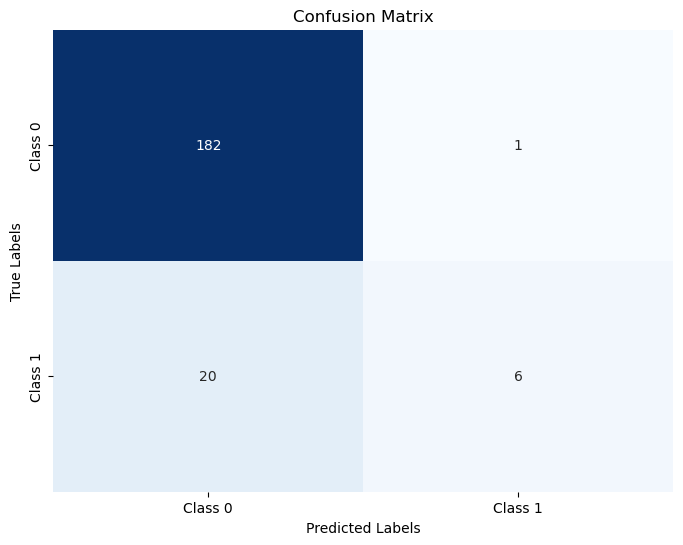

In [160]:
param_grid5av = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1.0, 0.01))
}
best_params5av, best_model5av = grid_searcher(param_grid5av, best_model5aiv, 'matthews_corrcoef')
model_test(best_model5av)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 2.261568784713745 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


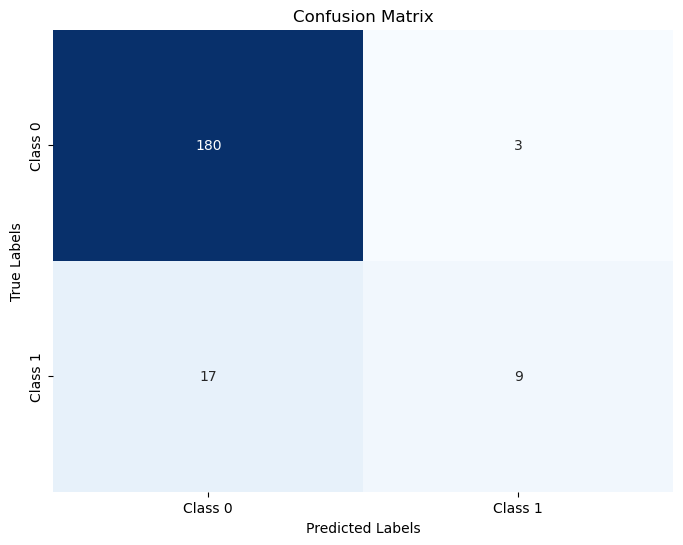

In [163]:
param_grid5av = {
    'max_features': ['sqrt', 'log2'] # + list(np.arange(0.5, 1.0, 0.01))
}
best_params5av, best_model5av = grid_searcher(param_grid5av, best_model5aiv, 'matthews_corrcoef')
model_test(best_model5av)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Time taken: 1.4262299537658691 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


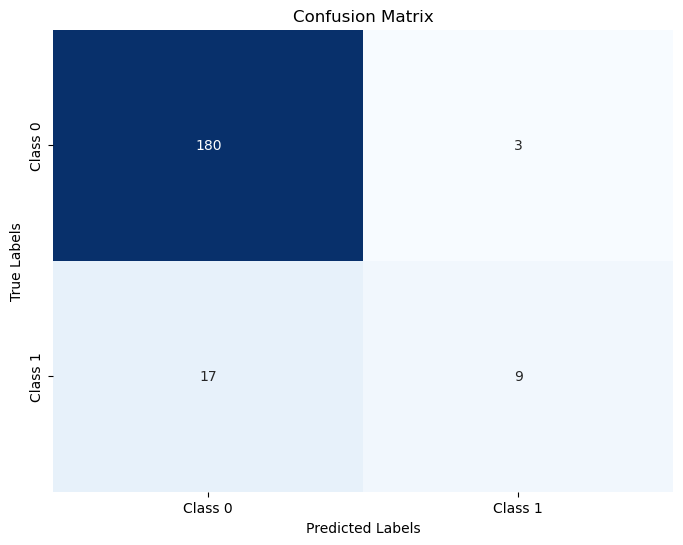

In [161]:
param_grid5aiii = {
    'bootstrap': [True]
}
best_params5aiii, best_model5aiii = grid_searcher(param_grid5aiii, best_model5aii, 'matthews_corrcoef')
model_test(best_model5aiii)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 5.976243257522583 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


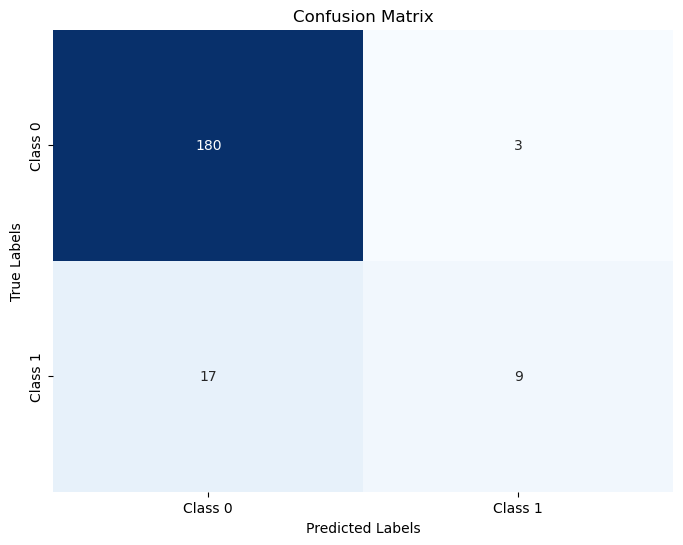

In [162]:
param_grid5aiv = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params5aiv, best_model5aiv = grid_searcher(param_grid5aiv, best_model5aiii, 'matthews_corrcoef')
model_test(best_model5aiv)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 34.58422255516052 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


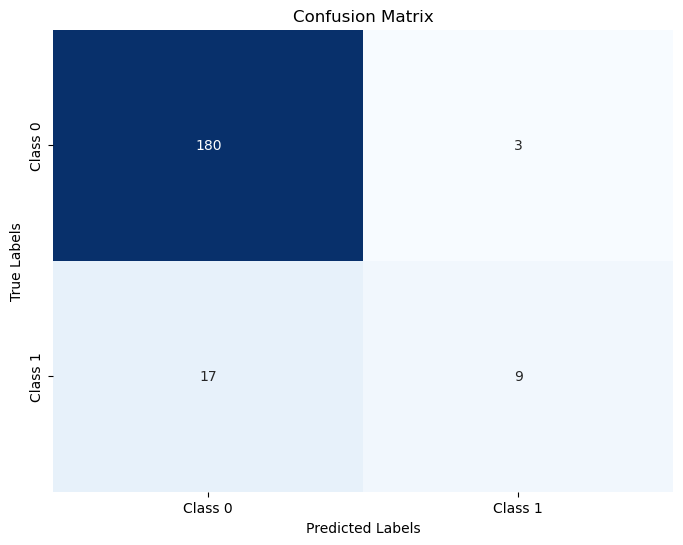

In [164]:
param_grid5av = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1.0, 0.01))
}
best_params5av, best_model5av = grid_searcher(param_grid5av, best_model5aiv, 'matthews_corrcoef')
model_test(best_model5av)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 2.0668036937713623 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


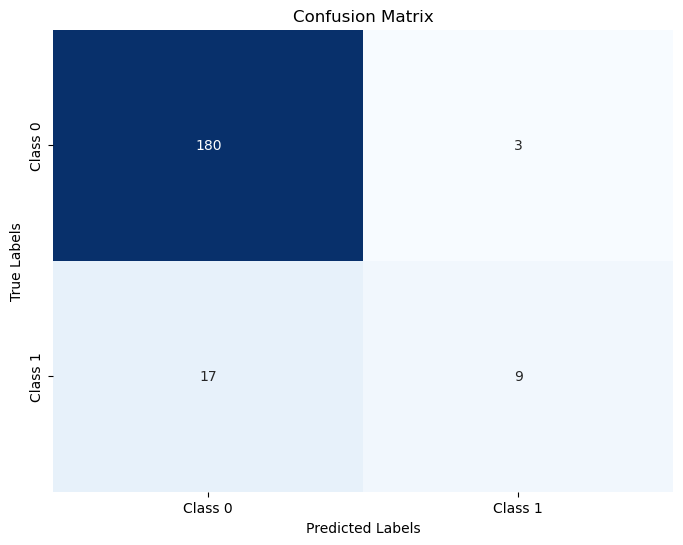

In [165]:
param_grid5av = {
    'max_features': ['sqrt', 'log2'] # + list(np.arange(0.5, 1.0, 0.01))
}
best_params5av, best_model5av = grid_searcher(param_grid5av, best_model5aiv, 'matthews_corrcoef')
model_test(best_model5av)

In [112]:
# AVERAGE_PRECISION

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Time taken: 91.44401526451111 seconds
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.88      0.27      0.41        26

    accuracy                           0.90       209
   macro avg       0.89      0.63      0.68       209
weighted avg       0.90      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


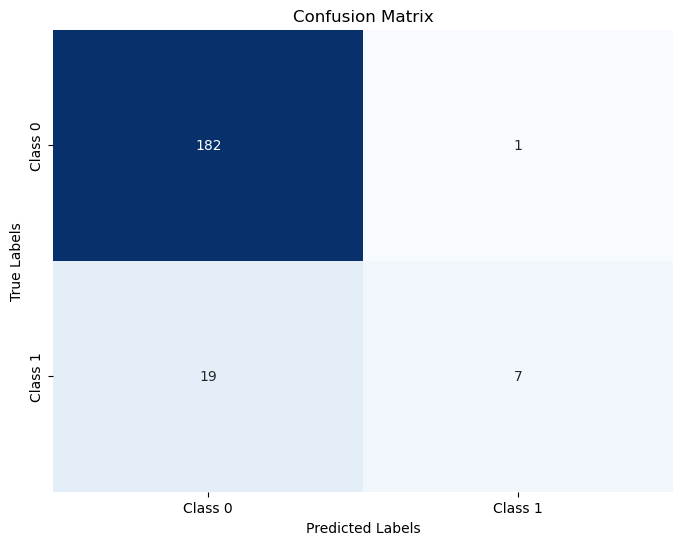

In [113]:
param_grid6 = {
    'n_estimators': [50, 70, 80],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params6, best_model6 = grid_searcher(param_grid6, model1, 'average_precision')
model_test(best_model6)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Time taken: 12.583735466003418 seconds
Best Hyperparameters: {'n_estimators': 110}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.82      0.35      0.49        26

    accuracy                           0.91       209
   macro avg       0.87      0.67      0.72       209
weighted avg       0.90      0.91      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


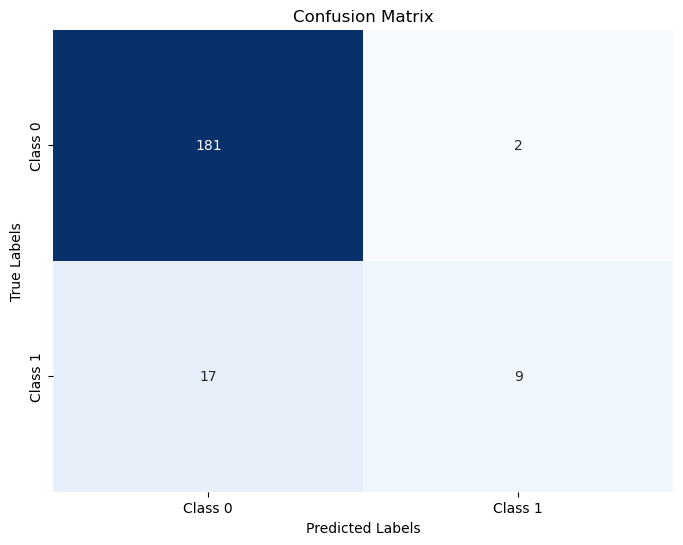

In [145]:
param_grid6a = {
    'n_estimators': list(np.arange(50, 201, 10)),
}
best_params6a, best_model6a = grid_searcher(param_grid6a, model1, 'average_precision')
model_test(best_model6a)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Time taken: 10.625600814819336 seconds
Best Hyperparameters: {'max_depth': None}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.82      0.35      0.49        26

    accuracy                           0.91       209
   macro avg       0.87      0.67      0.72       209
weighted avg       0.90      0.91      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


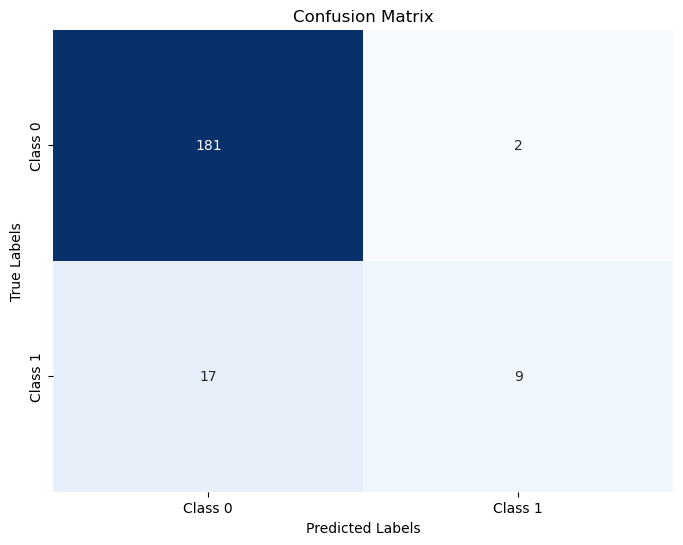

In [146]:
param_grid6ai = {
    'max_depth': [None] + list(np.arange(5, 31)),
}
best_params6ai, best_model6ai = grid_searcher(param_grid6ai, best_model6a, 'average_precision')
model_test(best_model6ai)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 5.856666803359985 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.82      0.35      0.49        26

    accuracy                           0.91       209
   macro avg       0.87      0.67      0.72       209
weighted avg       0.90      0.91      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


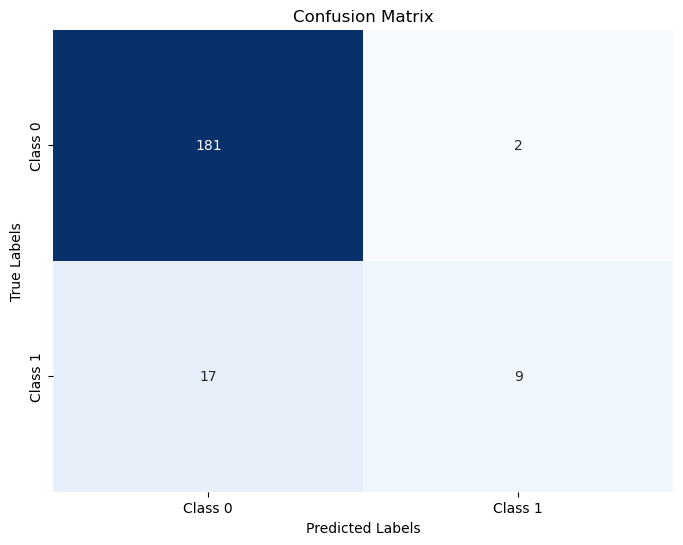

In [147]:
param_grid6aii = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params6aii, best_model6aii = grid_searcher(param_grid6aii, best_model6ai, 'average_precision')
model_test(best_model6aii)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.609015941619873 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.82      0.35      0.49        26

    accuracy                           0.91       209
   macro avg       0.87      0.67      0.72       209
weighted avg       0.90      0.91      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


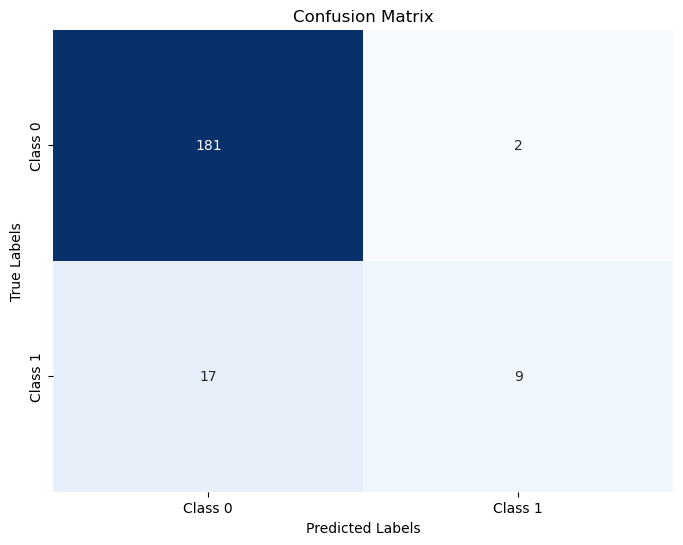

In [150]:
param_grid6aiii = {
    'bootstrap': [True, False]
}
best_params6aiii, best_model6aiii = grid_searcher(param_grid6aiii, best_model6aii, 'average_precision')
model_test(best_model6aiii)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 4.341763019561768 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.82      0.35      0.49        26

    accuracy                           0.91       209
   macro avg       0.87      0.67      0.72       209
weighted avg       0.90      0.91      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


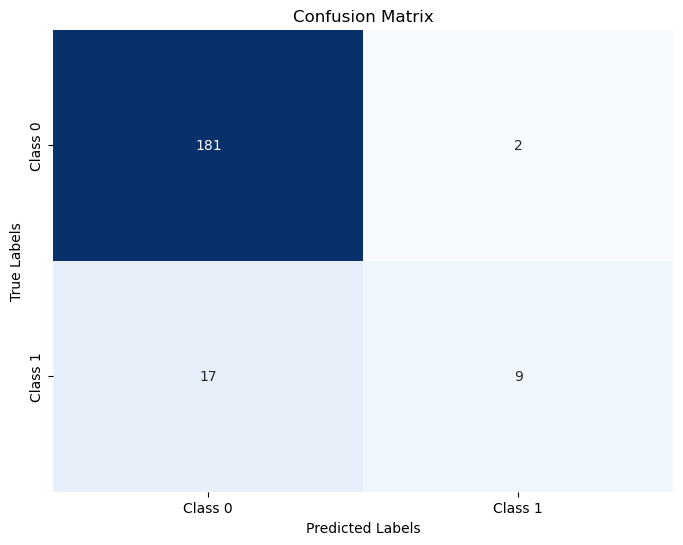

In [151]:
param_grid6aiv = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params6aiv, best_model6aiv = grid_searcher(param_grid6aiv, best_model6aiii, 'average_precision')
model_test(best_model6aiv)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.6433923244476318 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.82      0.35      0.49        26

    accuracy                           0.91       209
   macro avg       0.87      0.67      0.72       209
weighted avg       0.90      0.91      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


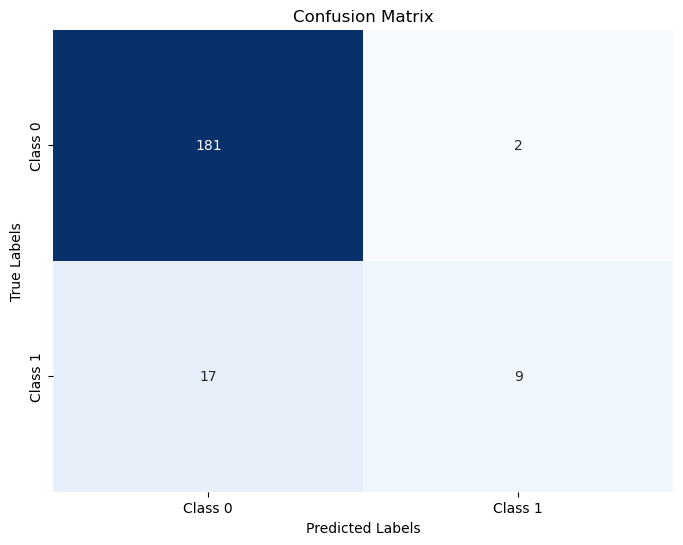

In [153]:
param_grid6av = {
    'max_features': ['sqrt', 'log2'] # + list(np.arange(0.5, 1.0, 0.01))
}
best_params6av, best_model6av = grid_searcher(param_grid6av, best_model6aiv, 'average_precision')
model_test(best_model6av)

In [114]:
# BALANCED_ACCURACY

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Time taken: 92.87226963043213 seconds
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.88      0.27      0.41        26

    accuracy                           0.90       209
   macro avg       0.89      0.63      0.68       209
weighted avg       0.90      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


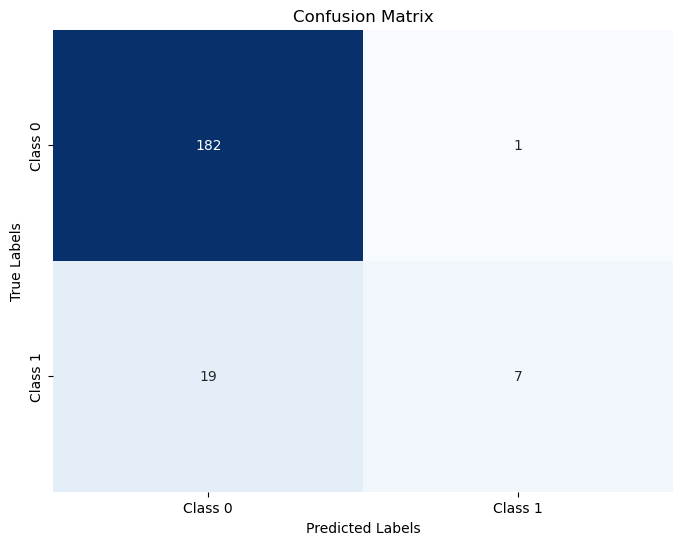

In [117]:
param_grid7 = {
    'n_estimators': [50, 70, 80],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params7, best_model7 = grid_searcher(param_grid7, model1, 'balanced_accuracy')
model_test(best_model7)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Time taken: 8.138750314712524 seconds
Best Hyperparameters: {'n_estimators': 120}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.80      0.31      0.44        26

    accuracy                           0.90       209
   macro avg       0.85      0.65      0.70       209
weighted avg       0.90      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


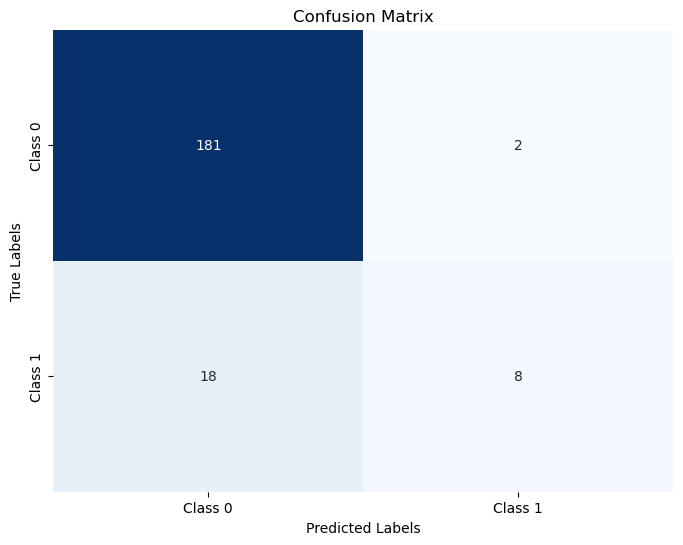

In [131]:
param_grid7a = {
    'n_estimators': list(np.arange(50, 201, 10)),
}
best_params7a, best_model7a = grid_searcher(param_grid7a, model1, 'balanced_accuracy')
model_test(best_model7a)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Time taken: 11.474137544631958 seconds
Best Hyperparameters: {'max_depth': None}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.80      0.31      0.44        26

    accuracy                           0.90       209
   macro avg       0.85      0.65      0.70       209
weighted avg       0.90      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


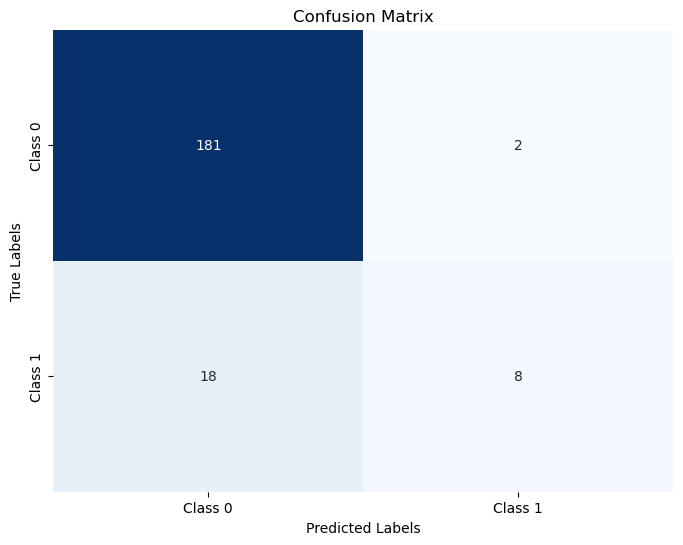

In [132]:
param_grid7ai = {
    'max_depth': [None] + list(np.arange(5, 31)),
}
best_params7ai, best_model7ai = grid_searcher(param_grid7ai, best_model7a, 'balanced_accuracy')
model_test(best_model7ai)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 6.30265212059021 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.80      0.31      0.44        26

    accuracy                           0.90       209
   macro avg       0.85      0.65      0.70       209
weighted avg       0.90      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


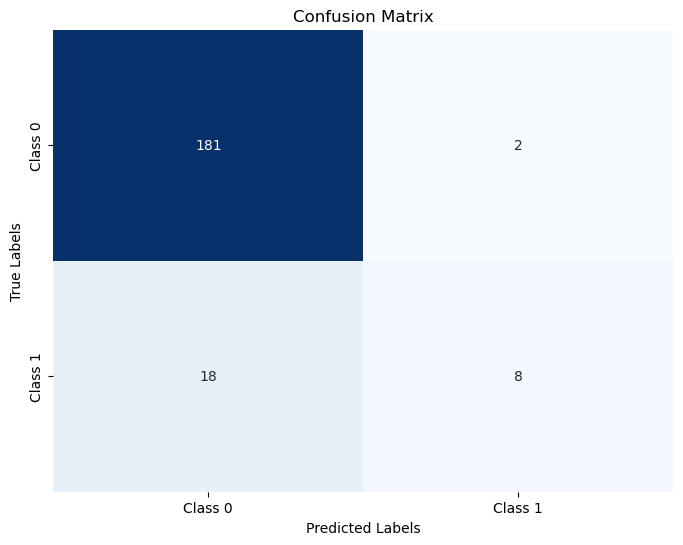

In [133]:
param_grid7aii = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params7aii, best_model7aii = grid_searcher(param_grid7aii, best_model7ai, 'balanced_accuracy')
model_test(best_model7aii)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 1.5672554969787598 seconds
Best Hyperparameters: {'bootstrap': False}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.99      0.94       183
     Class 1       0.80      0.15      0.26        26

    accuracy                           0.89       209
   macro avg       0.85      0.57      0.60       209
weighted avg       0.88      0.89      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        22 |         4 |
+-----------+-----------+


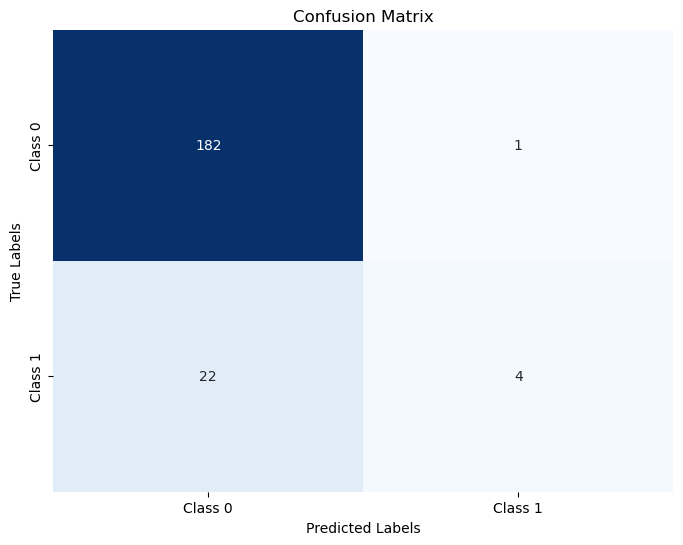

In [135]:
param_grid7aiii = {
    'bootstrap': [True, False]
}
best_params7aiii, best_model7aiii = grid_searcher(param_grid7aiii, best_model7aii, 'balanced_accuracy')
model_test(best_model7aiii)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 3.9909915924072266 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.99      0.94       183
     Class 1       0.80      0.15      0.26        26

    accuracy                           0.89       209
   macro avg       0.85      0.57      0.60       209
weighted avg       0.88      0.89      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        22 |         4 |
+-----------+-----------+


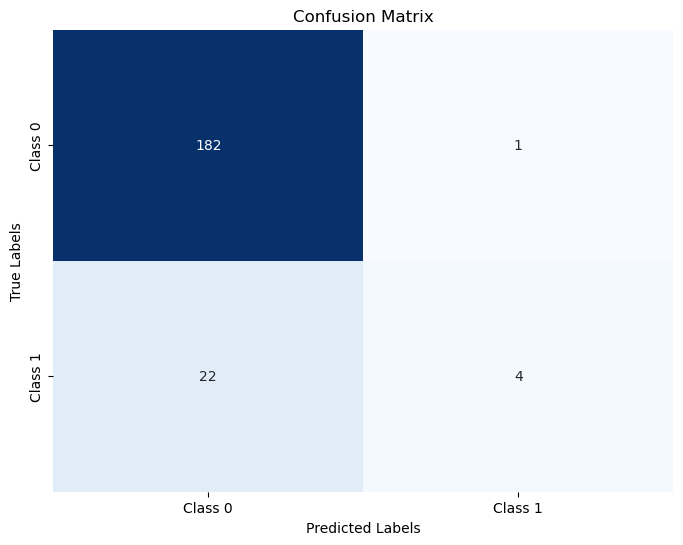

In [139]:
param_grid7aiv = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params7aiv, best_model7aiv = grid_searcher(param_grid7aiv, best_model7aiii, 'balanced_accuracy')
model_test(best_model7aiv)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 27.432698249816895 seconds
Best Hyperparameters: {'max_features': 'log2'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.88      0.27      0.41        26

    accuracy                           0.90       209
   macro avg       0.89      0.63      0.68       209
weighted avg       0.90      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


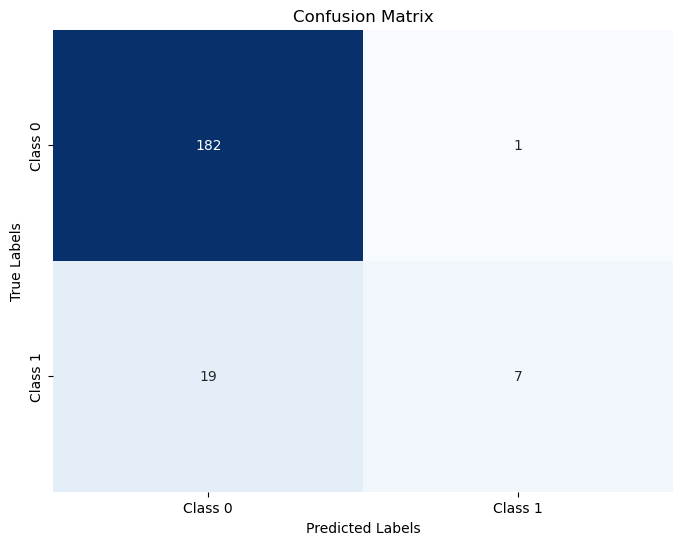

In [140]:
param_grid7av = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1.0, 0.01))
}
best_params7av, best_model7av = grid_searcher(param_grid7av, best_model7aiv, 'balanced_accuracy')
model_test(best_model7av)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Time taken: 1.190732479095459 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.80      0.31      0.44        26

    accuracy                           0.90       209
   macro avg       0.85      0.65      0.70       209
weighted avg       0.90      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


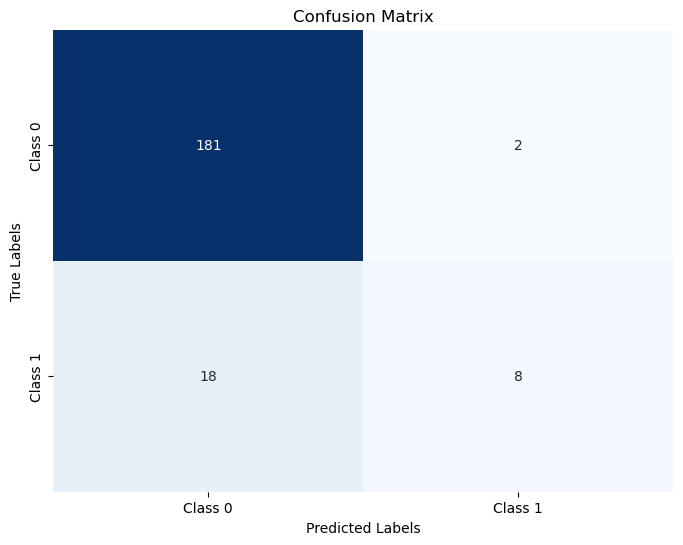

In [141]:
param_grid7aiii = {
    'bootstrap': [True]
}
best_params7aiii, best_model7aiii = grid_searcher(param_grid7aiii, best_model7aii, 'balanced_accuracy')
model_test(best_model7aiii)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 5.143469572067261 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.80      0.31      0.44        26

    accuracy                           0.90       209
   macro avg       0.85      0.65      0.70       209
weighted avg       0.90      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


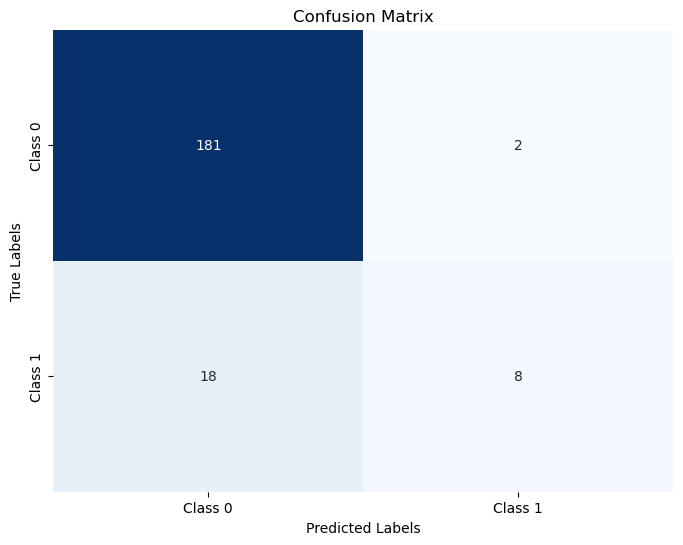

In [142]:
param_grid7aiv = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params7aiv, best_model7aiv = grid_searcher(param_grid7aiv, best_model7aiii, 'balanced_accuracy')
model_test(best_model7aiv)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 28.198956966400146 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.80      0.31      0.44        26

    accuracy                           0.90       209
   macro avg       0.85      0.65      0.70       209
weighted avg       0.90      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


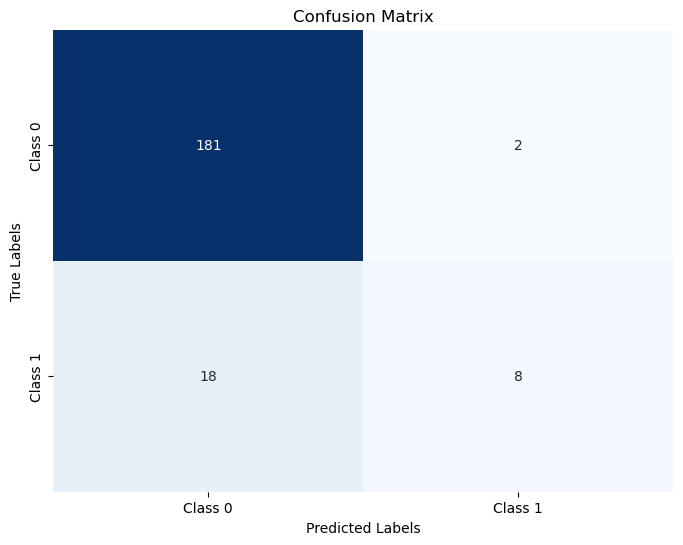

In [143]:
param_grid7av = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1.0, 0.01))
}
best_params7av, best_model7av = grid_searcher(param_grid7av, best_model7aiv, 'balanced_accuracy')
model_test(best_model7av)

In [115]:
# JACCARD

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Time taken: 93.90344452857971 seconds
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       183
     Class 1       0.88      0.27      0.41        26

    accuracy                           0.90       209
   macro avg       0.89      0.63      0.68       209
weighted avg       0.90      0.90      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


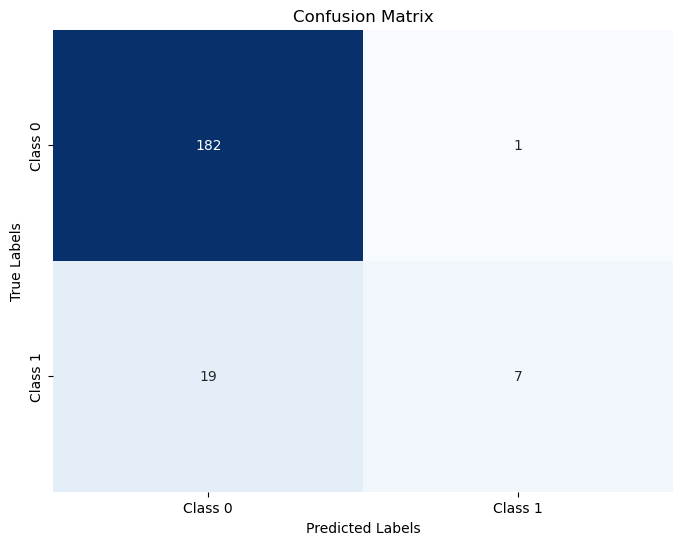

In [116]:
param_grid8 = {
    'n_estimators': [50, 70, 80],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
best_params8, best_model8 = grid_searcher(param_grid8, model1, 'jaccard')
model_test(best_model8)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Time taken: 12.123741626739502 seconds
Best Hyperparameters: {'n_estimators': 150}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


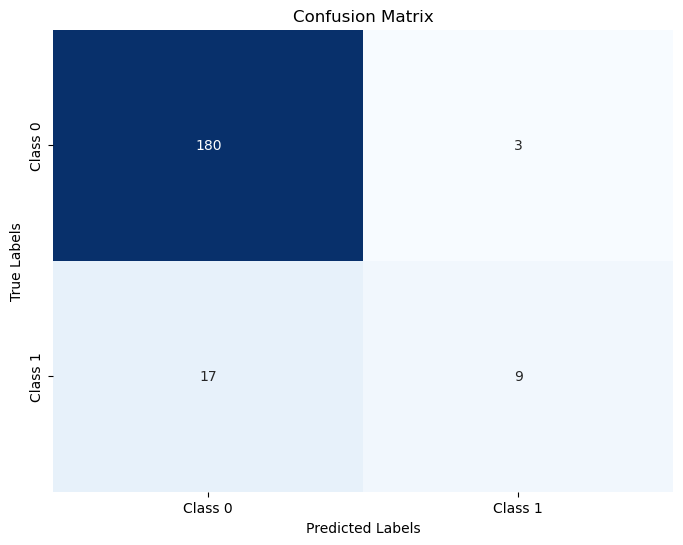

In [119]:
param_grid8a = {
    'n_estimators': list(np.arange(50, 201, 10)),
}
best_params8a, best_model8a = grid_searcher(param_grid8a, model1, 'jaccard')
model_test(best_model8a)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Time taken: 15.574433088302612 seconds
Best Hyperparameters: {'max_depth': 23}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


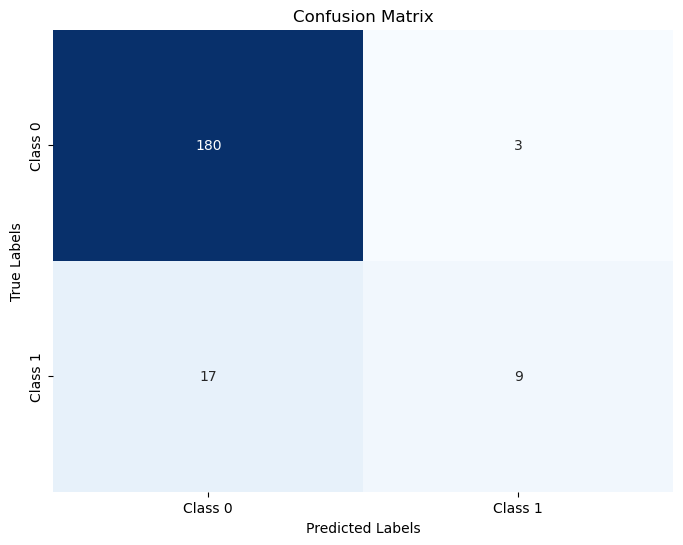

In [122]:
param_grid8ai = {
    'max_depth': [None] + list(np.arange(5, 31)),
}
best_params8ai, best_model8ai = grid_searcher(param_grid8ai, best_model8a, 'jaccard')
model_test(best_model8ai)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Time taken: 7.740700721740723 seconds
Best Hyperparameters: {'min_samples_split': 2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


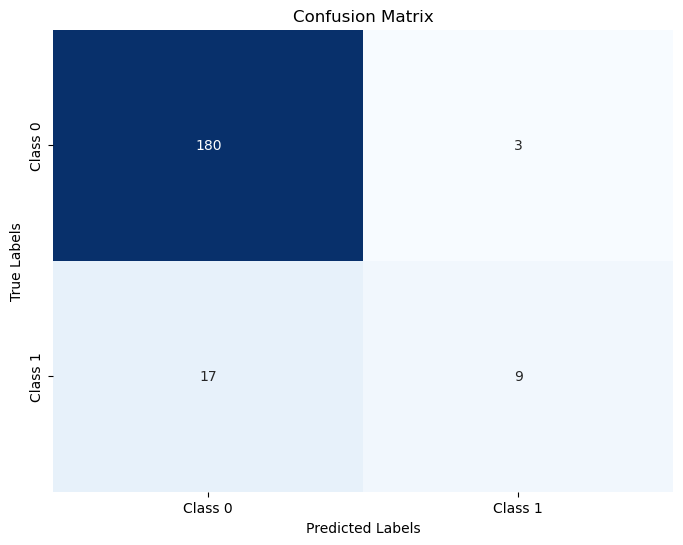

In [124]:
param_grid8aii = {
    'min_samples_split': list(np.arange(2, 16)),
}
best_params8aii, best_model8aii = grid_searcher(param_grid8aii, best_model8ai, 'jaccard')
model_test(best_model8aii)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Time taken: 1.3289458751678467 seconds
Best Hyperparameters: {'bootstrap': True}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


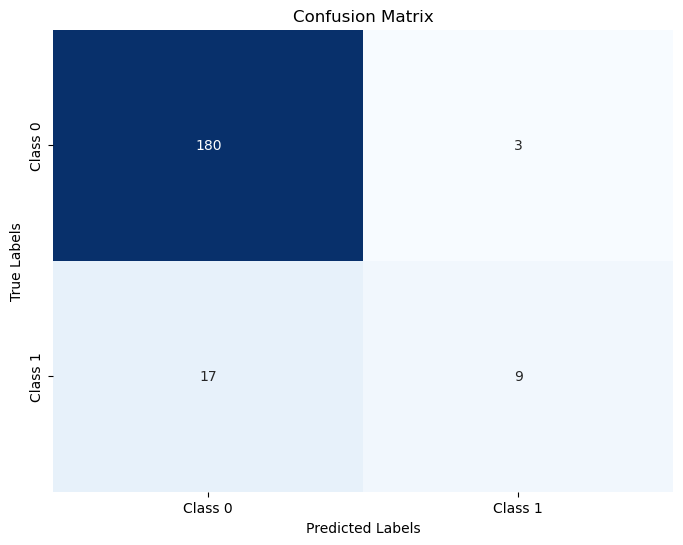

In [126]:
param_grid8aiii = {
    'bootstrap': [True], # , False]
}
best_params8aiii, best_model8aiii = grid_searcher(param_grid8aiii, best_model8aii, 'jaccard')
model_test(best_model8aiii)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 5.8799707889556885 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


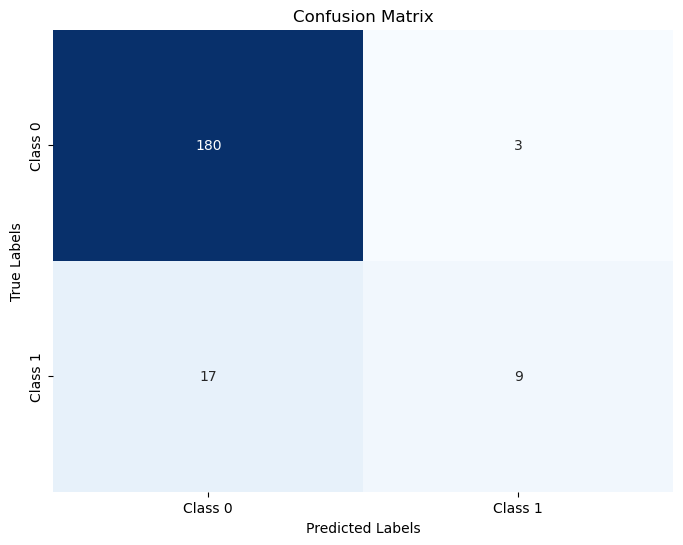

In [127]:
param_grid8aiv = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params8aiv, best_model8aiv = grid_searcher(param_grid8aiv, best_model8aiii, 'jaccard')
model_test(best_model8aiv)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 36.55607295036316 seconds
Best Hyperparameters: {'max_features': 'sqrt'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.98      0.95       183
     Class 1       0.75      0.35      0.47        26

    accuracy                           0.90       209
   macro avg       0.83      0.66      0.71       209
weighted avg       0.89      0.90      0.89       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


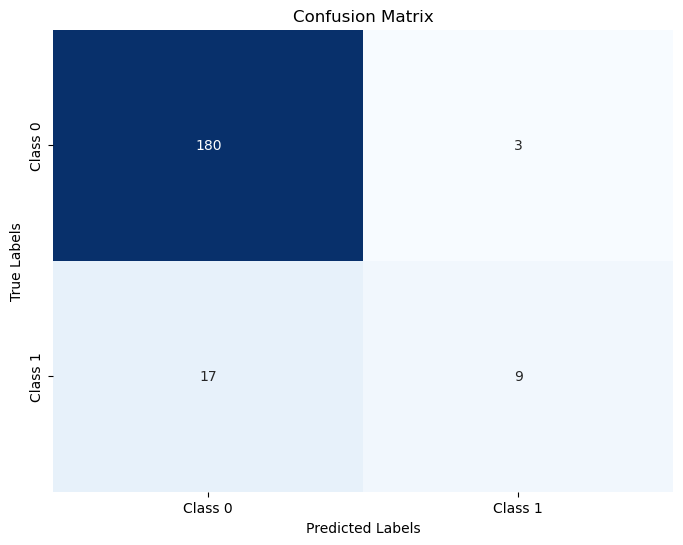

In [130]:
param_grid8av = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1.0, 0.01))
}
best_params8av, best_model8av = grid_searcher(param_grid8av, best_model8aiv, 'jaccard')
model_test(best_model8av)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Time taken: 2.017878293991089 seconds
Best Hyperparameters: {'bootstrap': False}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.99      0.94       183
     Class 1       0.80      0.15      0.26        26

    accuracy                           0.89       209
   macro avg       0.85      0.57      0.60       209
weighted avg       0.88      0.89      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        22 |         4 |
+-----------+-----------+


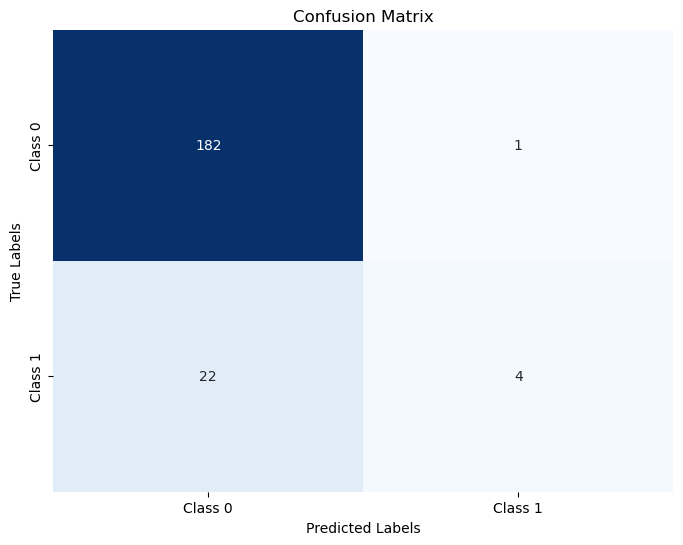

In [136]:
param_grid8aiii = {
    'bootstrap': [True, False]
}
best_params8aiii, best_model8aiii = grid_searcher(param_grid8aiii, best_model8aii, 'jaccard')
model_test(best_model8aiii)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Time taken: 5.277390718460083 seconds
Best Hyperparameters: {'min_samples_leaf': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.99      0.94       183
     Class 1       0.80      0.15      0.26        26

    accuracy                           0.89       209
   macro avg       0.85      0.57      0.60       209
weighted avg       0.88      0.89      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        22 |         4 |
+-----------+-----------+


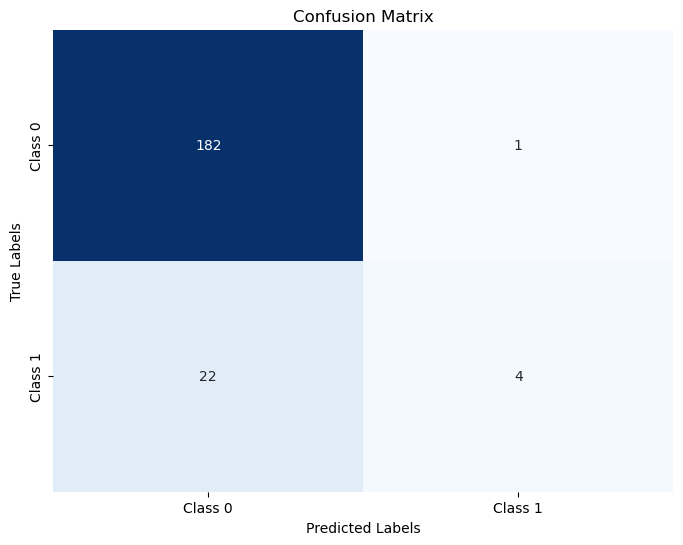

In [137]:
param_grid8aiv = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}
best_params8aiv, best_model8aiv = grid_searcher(param_grid8aiv, best_model8aiii, 'jaccard')
model_test(best_model8aiv)

Fitting 10 folds for each of 52 candidates, totalling 520 fits
Time taken: 34.57738542556763 seconds
Best Hyperparameters: {'max_features': 'log2'}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.99      0.95       183
     Class 1       0.86      0.23      0.36        26

    accuracy                           0.90       209
   macro avg       0.88      0.61      0.65       209
weighted avg       0.90      0.90      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


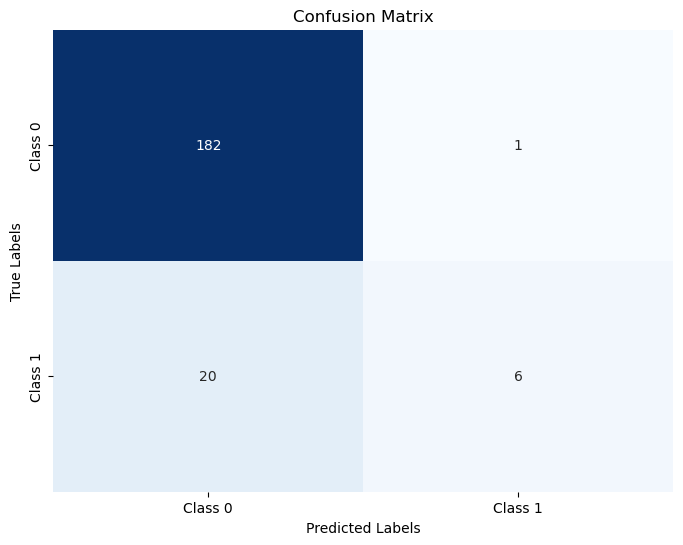

In [138]:
param_grid8av = {
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.5, 1.0, 0.01))
}
best_params8av, best_model8av = grid_searcher(param_grid8av, best_model8aiv, 'jaccard')
model_test(best_model8av)